# **Preliminares**

In [1]:
!pip install torchinfo optuna botorch gpytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.6 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/ealeongomez/MSRRFF-Wind-Forecast.git

Cloning into 'MSRRFF-Wind-Forecast'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 68 (delta 20), reused 61 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 17.86 MiB | 15.97 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [3]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, pickle
import pprint
from tqdm import tqdm
from scipy.interpolate import griddata
from collections import defaultdict
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import optuna
import optuna.visualization as vis
import optuna.importance
#from optuna_integration.botorch import BoTorchSampler
from optuna.samplers import TPESampler
from optuna.samplers import GPSampler
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate
from optuna.pruners import MedianPruner

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

import warnings
warnings.filterwarnings("ignore")

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_trials_per_type = 5

# **Load dataset**

In [5]:
def detect_environment():
    # Kaggle
    if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
        return "Kaggle"

    # Google Colab
    try:
        import google.colab
        pkl_filename = "/content/MSRRFF-Wind-Forecast/data/processed/data_dict.pkl"
        return "Google Colab", pkl_filename
    except ImportError:
        pass
    # Local u otro entorno
    return "Local/Other"

value_, pkl_filename = detect_environment()

print("Entorno detectado:", value_)


Entorno detectado: Google Colab


In [6]:
with open(pkl_filename, "rb") as f:
    data_dict_loaded = pickle.load(f)

In [7]:
def make_loader(X_arr, y_arr, batch_size, shuffle=False):
    ds = TensorDataset(torch.tensor(X_arr, dtype=torch.float32), torch.tensor(y_arr, dtype=torch.float32))
    return DataLoader(ds, batch_size=batch_size, shuffle=False)

In [8]:
data_dict_loaded.keys()

dict_keys(['Synthetic', 'Netherlands-0', 'Netherlands-1', 'Netherlands-2', 'Chengdu', 'Argonne', 'Beijing'])

In [9]:
names_TSF = ['Synthetic']

In [10]:
data_dict_loaded.keys()

dict_keys(['Synthetic', 'Netherlands-0', 'Netherlands-1', 'Netherlands-2', 'Chengdu', 'Argonne', 'Beijing'])

In [11]:
data_dict_loaded[names_TSF[0]].keys()

dict_keys(['X', 'Y', 'time_series', 'Max'])

In [12]:
data_dict_loaded[names_TSF[0]]['Max']

np.float64(7.059362311842034)

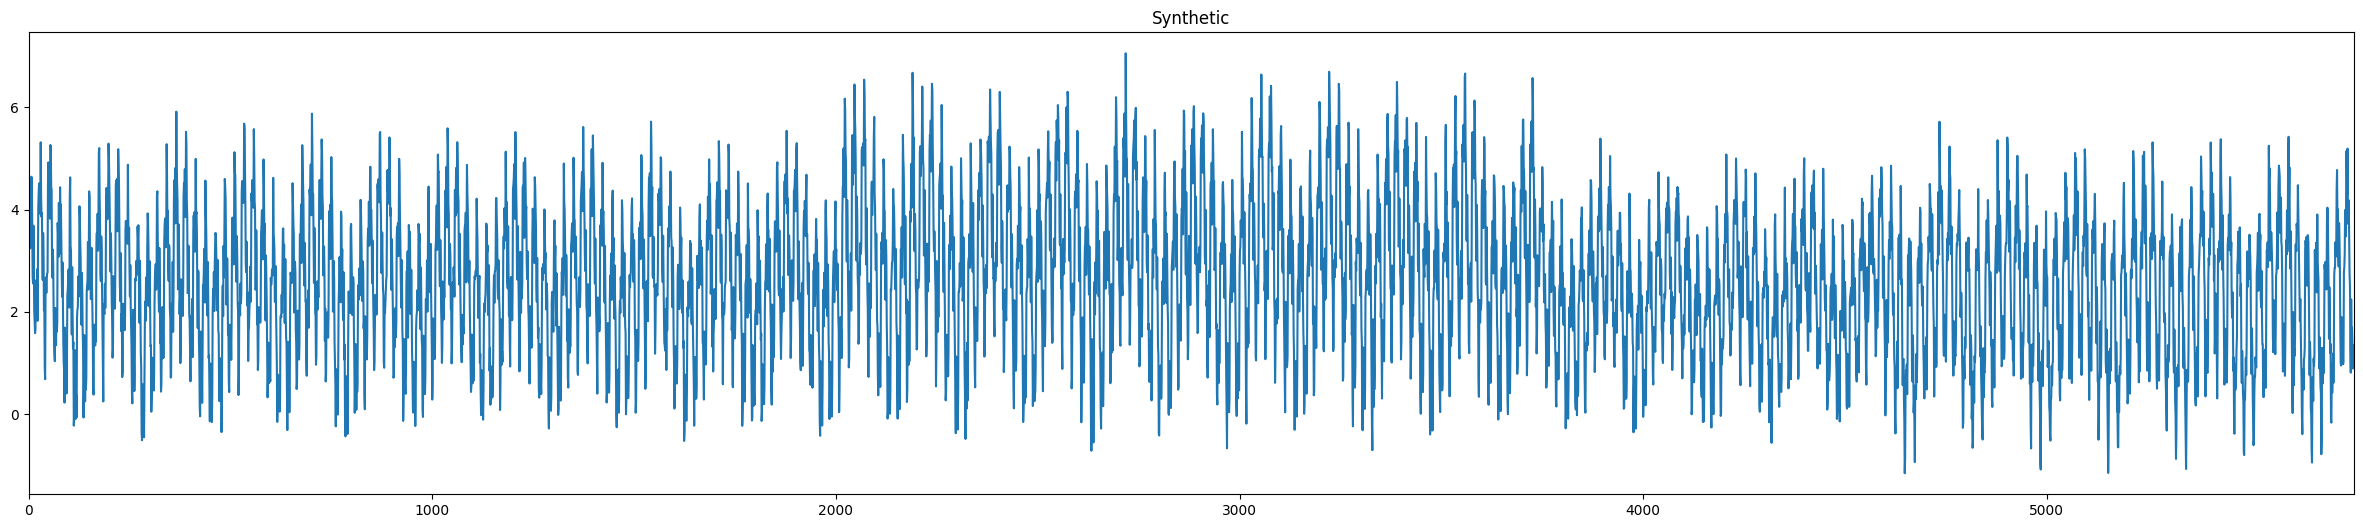

In [13]:
plt.figure(figsize=(30, 6))
plt.plot(data_dict_loaded[names_TSF[0]]['time_series'])
plt.title(names_TSF[0])
plt.xlim(0, len(data_dict_loaded[names_TSF[0]]['time_series']))
plt.show()

In [14]:
data = {}

for folder_name in names_TSF:
    print(f"\nFolder: {folder_name}")

    # Inicializar sección
    data[folder_name] = {}

    X = data_dict_loaded[f"{folder_name}"]['X']
    Y = data_dict_loaded[f"{folder_name}"]['Y']

    print(X.shape, Y.shape)

    X = X[..., np.newaxis]  # Expand dims for CNN

    print(X.shape, Y.shape)

    # Train/Validation/Test splits
    X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    if folder_name == "Etiopia-April" or folder_name == "Etiopia-May":
        batch_size = 64
    else:
        batch_size = 256

    train_loader = make_loader(X_train, y_train, batch_size)
    valid_loader = make_loader(X_valid, y_valid, batch_size)
    test_loader  = make_loader(X_test,  y_test, batch_size)

    data[folder_name] = {"loaders": {"train": train_loader, "valid": valid_loader, "test":  test_loader}}


Folder: Synthetic
(5639, 96) (5639, 24)
(5639, 96, 1) (5639, 24)


In [15]:
batch = next(iter(data[folder_name]["loaders"]["train"]))

if isinstance(batch, (list, tuple)):
    xb_sample, y_sample = batch
else:
    xb_sample = batch["x"]
    y_sample = batch["y"]

W = xb_sample.shape[1]
n_features = xb_sample.shape[2]
H = y_sample.shape[1]

print(f"Ventana W={W} | Features F={n_features} | Horizonte H={H}")


Ventana W=96 | Features F=1 | Horizonte H=24


# **Models**

## Transformers

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # shape: (1, max_len, d_model)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, L, d_model)
        """
        L = x.size(1)
        return x + self.pe[:, :L]


In [17]:
# ===========================================================
# SimpleTransformerTS v2
# Encoder-Decoder para forecasting multi-horizonte
# ===========================================================
class SimpleTransformerTS(nn.Module):
    def __init__(
        self,
        input_dim: int,      # F: nº de features por tiempo
        d_model: int,        # dimensión interna del Transformer
        nhead: int,
        num_layers_enc: int,
        num_layers_dec: int,
        horizon: int,        # H: nº de pasos de predicción
        dropout: float = 0.1,
        max_len: int = 500
    ):
        super().__init__()
        self.horizon = horizon
        self.d_model = d_model

        # Proyección de entrada (F -> d_model)
        self.input_proj = nn.Linear(input_dim, d_model)

        # Codificación posicional
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        # Encoder Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,  # para usar (B, L, d)
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers_enc
        )

        # Tokens de horizonte como queries del decoder
        self.horizon_queries = nn.Parameter(
            torch.randn(horizon, d_model)
        )

        # Decoder Transformer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
        )
        self.decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_dec
        )

        # Head final: d_model -> 1 por horizonte
        self.head = nn.Linear(d_model, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, W, F)  → salida: (B, H)
        """
        B, W, F = x.shape

        # ---- Encoder ----
        src = self.input_proj(x)         # (B, W, d_model)
        src = self.pos_encoder(src)      # (B, W, d_model)
        memory = self.encoder(src)       # (B, W, d_model)

        # ---- Decoder ----
        # Crear H queries repetidas para todo el batch
        # horizon_queries: (H, d_model) -> (1, H, d_model) -> (B, H, d_model)
        tgt = self.horizon_queries.unsqueeze(0).expand(B, self.horizon, self.d_model)
        tgt = self.pos_encoder(tgt)      # (B, H, d_model)

        # Decoder: cada posición de horizonte "ve" toda la memoria del encoder
        dec_out = self.decoder(tgt=tgt, memory=memory)  # (B, H, d_model)

        # Proyección a escalar (una salida por horizonte)
        out = self.head(dec_out).squeeze(-1)            # (B, H)

        return out


In [18]:
# ===========================================================
# Bloque de descomposición serie (trend + seasonal)
# ===========================================================
class SeriesDecomp(nn.Module):
    def __init__(self, kernel_size: int = 25):
        super().__init__()
        # Moving average como convolución 1D (sobre el eje temporal)
        padding = (kernel_size - 1) // 2
        self.avg_pool = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=kernel_size,
            padding=padding,
            bias=False
        )
        # Inicializar como media uniforme
        nn.init.constant_(self.avg_pool.weight, 1.0 / kernel_size)

    def forward(self, x: torch.Tensor):
        """
        x: (B, L, d_model)
        Devuelve:
          trend:   (B, L, d_model)
          seasonal:(B, L, d_model)
        """
        B, L, D = x.shape
        # Aplicar moving average por cada dimensión de features
        trend_list = []
        for d in range(D):
            # x[..., d] -> (B, L) -> (B, 1, L) para conv1d
            xd = x[:, :, d].unsqueeze(1)
            td = self.avg_pool(xd)  # (B, 1, L)
            trend_list.append(td.squeeze(1))  # (B, L)
        trend = torch.stack(trend_list, dim=-1)          # (B, L, D)
        seasonal = x - trend
        return trend, seasonal

class AutoformerLite(nn.Module):
    def __init__(
        self,
        input_dim: int,
        d_model: int,
        nhead: int,
        num_layers: int,
        horizon: int,
        dropout: float = 0.1,
        kernel_size: int = 25,
        max_len: int = 500
    ):
        super().__init__()
        self.horizon = horizon

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Decomposición serie
        self.decomp = SeriesDecomp(kernel_size=kernel_size)

        # Proyecciones separadas para trend y seasonal
        self.trend_proj = nn.Linear(d_model, d_model)
        self.season_proj = nn.Linear(d_model, d_model)

        # Head final multi-horizonte
        self.head = nn.Linear(d_model, horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, W, F) -> salida: (B, H)
        """
        # Proyección + posición
        z = self.input_proj(x)           # (B, W, d_model)
        z = self.pos_encoder(z)
        enc_out = self.encoder(z)        # (B, W, d_model)

        # Decomposición serie (trend + seasonal)
        trend, seasonal = self.decomp(enc_out)  # (B, W, d_model) cada uno

        # Combinación lineal
        trend_part = self.trend_proj(trend)
        season_part = self.season_proj(seasonal)
        fused = trend_part + season_part      # (B, W, d_model)

        # Usar último tiempo como resumen de la ventana
        last_state = fused[:, -1, :]         # (B, d_model)

        # Head multi-horizonte
        out = self.head(last_state)          # (B, H)

        return out


In [19]:
# ===========================================================
# Bloque Fourier para selección de modos
# ===========================================================
class FourierBlock(nn.Module):
    def __init__(self, n_modes: int):
        """
        n_modes: nº de modos de baja frecuencia a preservar.
        """
        super().__init__()
        self.n_modes = n_modes

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, L, d_model)  -> salida: (B, L, d_model)
        Aplica FFT sobre el eje temporal y mantiene n_modes de baja frecuencia.
        """
        B, L, D = x.shape

        # FFT sobre el eje temporal
        Xf = torch.fft.rfft(x, dim=1)     # (B, L_f, D), L_f = L//2 + 1

        cutoff = min(self.n_modes, Xf.shape[1])
        # Crear tensor filtrado
        Xf_filtered = torch.zeros_like(Xf)
        Xf_filtered[:, :cutoff, :] = Xf[:, :cutoff, :]

        # Transformada inversa
        x_recon = torch.fft.irfft(Xf_filtered, n=L, dim=1)  # (B, L, D)
        return x_recon


# ===========================================================
# FEDformerLite v2
# FourierBlock + Encoder + head multi-horizonte
# ===========================================================
class FEDformerLite(nn.Module):
    def __init__(
        self,
        input_dim: int,
        d_model: int,
        nhead: int,
        num_layers: int,
        horizon: int,
        n_modes: int = 16,
        dropout: float = 0.1,
        max_len: int = 500
    ):
        super().__init__()
        self.horizon = horizon

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        # Bloque Fourier para reducción de modos
        self.fourier_block = FourierBlock(n_modes=n_modes)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Head multi-horizonte
        self.head = nn.Linear(d_model, horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, W, F) -> salida: (B, H)
        """
        # Proyección + posiciones
        z = self.input_proj(x)           # (B, W, d_model)
        z = self.pos_encoder(z)          # (B, W, d_model)

        # Reducción de modos en frecuencia temporal
        z_freq = self.fourier_block(z)   # (B, W, d_model)

        # Encoder Transformer
        enc_out = self.encoder(z_freq)   # (B, W, d_model)

        # Usar último tiempo como resumen
        last_state = enc_out[:, -1, :]   # (B, d_model)

        # Head multi-horizonte
        out = self.head(last_state)      # (B, H)

        return out


# **Train**

In [20]:
class TotalLoss(nn.Module):
    def __init__(self, alpha_spec: float = 0.0, alpha_weight: float = 0.0):
        super().__init__()
        self.mse = nn.MSELoss()
        # alpha_* quedan ignorados en el baseline tradicional

    def forward(self, y_true, y_pred):
        # train_model llama criterion(yb, preds): (y_true, y_pred)
        return F.mse_loss(y_pred, y_true)

def ts_augment(x):
    return x

In [21]:
def train_model(model, data, folder_name, num_epochs=100, lr=1e-3, device="cuda", trial=None, lr_rho_multiplier: float = 1.0, log_per_batch: bool = False):
    """
    Versión mejorada con:
      ✅ Compatibilidad con nuevas clases (RecurrentRFFForecast, MultiScaleRFF)
      ✅ Data augmentation temporal (ts_augment)
      ✅ Pérdida combinada TotalLoss (Huber ponderado + Espectral)
      ✅ Logging automático de ℓ (bandwidth) si el modelo usa RFF
    """
    from collections import defaultdict
    import torch.optim as optim
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    loaders = data[folder_name]["loaders"]
    train_loader = loaders["train"]
    valid_loader = loaders["valid"]
    test_loader  = loaders["test"]

    # =============================================================
    # Helpers internos
    # =============================================================
    def _iter_rff_modules(m):
        """Detecta módulos tipo RFF (DenseRFF_PT o MultiScaleRFF)."""
        target_class_names = ["DenseRFF_PT", "MultiScaleRFF"]
        for sub in m.modules():
            name_ok = (sub.__class__.__name__ in target_class_names)
            has_attrs = any(hasattr(sub, a) for a in ["kernel_scale", "bandwidth_lengthscale", "log_bandwidth", "scale"])
            if name_ok or has_attrs:
                yield sub

    def _safe_item(x):
        try:
            return float(x.detach().cpu().item())
        except Exception:
            try:
                return float(x)
            except Exception:
                return None

    def _compute_ell_if_possible(rff):
        """Intenta obtener una 'longitud de banda' interpretable."""
        if hasattr(rff, "bandwidth_lengthscale"):
            try:
                ell = rff.bandwidth_lengthscale()
                if isinstance(ell, (list, tuple)):
                    ell = ell[0]
                return _safe_item(ell)
            except Exception:
                pass

        try:
            scale = getattr(rff, "scale", None)
            ksc   = getattr(rff, "kernel_scale", None)
            if scale is not None and ksc is not None:
                scale = _safe_item(scale)
                ksc   = _safe_item(ksc)
                if scale is not None and ksc is not None and ksc != 0.0:
                    return scale / ksc
        except Exception:
            pass

        return None

    # =============================================================
    # Inicialización de modelo y optimizador
    # =============================================================
    xb0, yb0 = next(iter(train_loader))
    window  = int(xb0.shape[1])
    horizon = int(yb0.shape[1])

    if hasattr(model, "fc2") and isinstance(model.fc2, nn.Linear) and model.fc2.out_features != horizon:
        model.fc2 = nn.Linear(model.fc2.in_features, horizon).to(device)

    model = model.to(device)

    with torch.no_grad():
        _ = model(xb0.to(device))

    named = list(model.named_parameters())
    rho_params   = [p for n, p in named if "rho_scale" in n and p.requires_grad]
    other_params = [p for n, p in named if "rho_scale" not in n and p.requires_grad]

    if lr_rho_multiplier != 1.0 and len(rho_params) > 0:
        optimizer = optim.Adam(
            [{"params": rho_params, "lr": lr * lr_rho_multiplier},
             {"params": other_params, "lr": lr}]
        )
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # ✅ Pérdida híbrida
    criterion = TotalLoss(alpha_spec=1e-3, alpha_weight=0.05)

    best_val = float("inf")
    history = {"train_loss": [], "valid_loss": []}

    # Detectar RFFs una sola vez (tras warm-up)
    rff_modules = list(_iter_rff_modules(model))
    has_rff = len(rff_modules) > 0
    ell_series = defaultdict(list)
    rff_names = {id(m): f"RFF_{i+1}_{m.__class__.__name__}" for i, m in enumerate(rff_modules)}

    def _log_bandwidths(step):
        """Calcula y guarda ℓ por cada capa RFF si es posible."""
        for m in rff_modules:
            ell = _compute_ell_if_possible(m)
            if ell is not None and np.isfinite(ell):
                ell_series[rff_names[id(m)]].append((step, float(ell)))
            if hasattr(m, "log_bandwidth"):
                try:
                    m.log_bandwidth(step=step)
                except Exception:
                    pass

    # =============================================================
    # Loop de entrenamiento
    # =============================================================
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        for batch_idx, (xb, yb) in enumerate(train_loader, start=1):
            xb, yb = xb.to(device), yb.to(device)

            # 🔹 Augmentación temporal
            xb = ts_augment(xb)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(yb, preds)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item() * xb.size(0)

            if log_per_batch and has_rff:
                global_step = (epoch - 1) * len(train_loader) + batch_idx
                _log_bandwidths(step=global_step)

        train_loss /= len(train_loader.dataset)

        # -------- Validación --------
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(yb, preds)
                valid_loss += loss.item() * xb.size(0)
        valid_loss /= len(valid_loader.dataset)

        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)

        if has_rff and not log_per_batch:
            _log_bandwidths(step=epoch)

        if epoch % 10 == 0:
            msg = f"Epoch {epoch:03d} | Train {train_loss:.4f} | Valid {valid_loss:.4f}"
            if has_rff:
                name0 = next(iter(rff_names.values()))
                last_series = ell_series.get(name0, [])
                if last_series:
                    msg += f" | ℓ={last_series[-1][1]:.4f}"
            print(msg)

        if valid_loss < best_val:
            best_val = valid_loss
            torch.save(model.state_dict(), f"best_model_{folder_name}.pth")

        if (trial is not None) and ("optuna" in globals()):
            trial.report(-valid_loss, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # =============================================================
    # Test y métricas
    # =============================================================
    model.load_state_dict(torch.load(f"best_model_{folder_name}.pth", map_location=device))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            y_true.append(yb.cpu())
            y_pred.append(preds.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    # --- Global ---
    r2   = float(r2_score(y_true, y_pred))
    mae  = float(mean_absolute_error(y_true, y_pred))
    mse  = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    print(f"Test GLOBAL | R2={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}")

    # --- Por horizonte ---
    H = y_true.shape[1]
    metrics_pointwise = {"horizon": [], "RMSE": [], "MAE": [], "R2": []}
    for h in range(H):
        yt = y_true[:, h]
        yp = y_pred[:, h]
        mse_h = mean_squared_error(yt, yp)
        rmse_h = np.sqrt(mse_h)
        mae_h  = mean_absolute_error(yt, yp)
        r2_h   = r2_score(yt, yp)
        metrics_pointwise["horizon"].append(h+1)
        metrics_pointwise["RMSE"].append(float(rmse_h))
        metrics_pointwise["MAE"].append(float(mae_h))
        metrics_pointwise["R2"].append(float(r2_h))
    df_pointwise = pd.DataFrame(metrics_pointwise)

    # --- Acumuladas ---
    metrics_cumulative = {"horizon": [], "RMSE": [], "MAE": [], "R2": []}
    for h in range(1, H+1):
        yt = y_true[:, :h].reshape(-1)
        yp = y_pred[:, :h].reshape(-1)
        mse_h = mean_squared_error(yt, yp)
        rmse_h = np.sqrt(mse_h)
        mae_h  = mean_absolute_error(yt, yp)
        r2_h   = r2_score(yt, yp)
        metrics_cumulative["horizon"].append(h)
        metrics_cumulative["RMSE"].append(float(rmse_h))
        metrics_cumulative["MAE"].append(float(mae_h))
        metrics_cumulative["R2"].append(float(r2_h))
    df_cumulative = pd.DataFrame(metrics_cumulative)

    # --- Logging de bandwidth ---
    """
    if has_rff and any(len(v) > 0 for v in ell_series.values()):
        x_label = "Step" if log_per_batch else "Epoch"
        for name, series in ell_series.items():
            if not series:
                continue
            steps, ells = zip(*series)
            plt.figure()
            plt.plot(steps, ells, marker="o")
            plt.xlabel(x_label)
            plt.ylabel("Bandwidth ℓ (aprox.)")
            plt.title(f"Evolución del ancho de banda — {name}")
            plt.tight_layout()
            out_fig = f"bandwidth_evolution_{folder_name}_{name}.png"
            plt.savefig(out_fig, dpi=150)
            print(f"[OK] Guardado: {out_fig}")
    """
    # --- Bandwidth logging: unified plot for all RFF layers ---
    if has_rff and any(len(v) > 0 for v in ell_series.values()):

        x_label = "Step" if log_per_batch else "Epoch"

        plt.figure(figsize=(10, 5))

        for module in rff_modules:
            key = rff_names[id(module)]
            series = ell_series[key]
            if not series:
                continue

            steps, ells = zip(*series)

            clean_name = key.replace(".", " → ")

            # --- Read actual mapping dimension ---
            Nf_value = getattr(module, "Nf", "?")

            legend_label = f"{clean_name} (Nf={Nf_value})"

            plt.plot(
                steps,
                ells,
                marker="o",
                linewidth=2,
                markersize=4,
                alpha=0.85,
                label=legend_label
            )

        plt.xlabel(x_label)
        plt.ylabel("Bandwidth ℓ (approx.)")
        plt.title(f"Bandwidth Evolution Across All RFF Layers\nDataset: {folder_name}")
        plt.legend(title="RFF Layers", loc="best")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        out_fig = f"bandwidth_evolution_ALL_RFF_{folder_name}.png"
        plt.savefig(out_fig, dpi=150)
        plt.close()

        print(f"[OK] Saved unified bandwidth plot: {out_fig}")

    return history, df_pointwise, df_cumulative, y_true, y_pred


In [22]:
def plot_reconstruction_per_horizon(y_true, y_pred, num_samples=500, folder_name="dataset"):
    N, H = y_true.shape
    num_samples = min(num_samples, N)

    for h in range(H):
        plt.figure(figsize=(14, 4))
        plt.plot(range(num_samples), y_true[:num_samples, h],
                 label=f"Real (h={h+1})", color="blue", linewidth=1.5)
        plt.plot(range(num_samples), y_pred[:num_samples, h],
                 label=f"Predicho (h={h+1})", color="red", linestyle="--")
        plt.title(f"Reconstrucción Test - {folder_name} (Horizonte {h+1})")
        plt.xlabel("Índice de muestra")
        plt.ylabel("Valor")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


# **Hiperparameters tunnig**

In [23]:
def build_model_from_trial(trial, model_name, input_dim, horizon):
    """
    Construye un modelo Transformer (o variante Autoformer/FEDformer) desde un trial de Optuna.
    Incluye validación automática de d_model y nhead.
    """

    # ==========================================================
    # Helper: seleccionar d_model / nhead válidos
    # ==========================================================
    def sample_transformer_dims():
        # Tamaños típicos y eficientes
        d_model = trial.suggest_categorical("d_model", [64, 96, 128, 192, 256])
        nhead   = trial.suggest_categorical("nhead", [1, 2, 4, 8])

        # Condición obligatoria: d_model divisible por nhead
        if d_model % nhead != 0:
            raise optuna.TrialPruned()

        return d_model, nhead

    # ==========================================================
    # 🔵 TRANSFORMER ESTÁNDAR (SimpleTransformerTS v2)
    # ==========================================================
    if model_name == "Transformer":
        d_model, nhead = sample_transformer_dims()

        # Profundidades encoder/decoder
        num_layers_enc = trial.suggest_int("num_layers_enc", 1, 4)
        num_layers_dec = trial.suggest_int("num_layers_dec", 1, 2)

        dropout = trial.suggest_float("dropout", 0.05, 0.3)

        model = SimpleTransformerTS(
            input_dim=input_dim,
            d_model=d_model,
            nhead=nhead,
            num_layers_enc=num_layers_enc,
            num_layers_dec=num_layers_dec,
            horizon=horizon,
            dropout=dropout
        )
        return model

    # ==========================================================
    # 🟣 AUTOFORMER LITE v2
    # ==========================================================
    if model_name == "Autoformer":
        d_model, nhead = sample_transformer_dims()

        num_layers = trial.suggest_int("num_layers", 1, 3)
        kernel_size = trial.suggest_categorical("kernel_size", [13, 25, 51])  # moving avg

        dropout = trial.suggest_float("dropout", 0.05, 0.3)

        model = AutoformerLite(
            input_dim=input_dim,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            horizon=horizon,
            dropout=dropout,
            kernel_size=kernel_size
        )
        return model

    # ==========================================================
    # 🟣 FEDFORMER LITE v2
    # ==========================================================
    if model_name == "FEDformer":
        d_model, nhead = sample_transformer_dims()

        num_layers = trial.suggest_int("num_layers", 1, 3)
        n_modes = trial.suggest_int("n_modes", 8, 32)
        dropout = trial.suggest_float("dropout", 0.05, 0.3)

        model = FEDformerLite(
            input_dim=input_dim,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            horizon=horizon,
            n_modes=n_modes,
            dropout=dropout
        )
        return model

    # ==========================================================
    raise ValueError(f"Modelo '{model_name}' no está soportado.")



In [24]:
def objective_factory_transformer(data, folder_name, device, model_name):

    def objective(trial):
        # 1. Detectar dimensiones
        xb0, yb0 = next(iter(data[folder_name]["loaders"]["train"]))
        input_dim = xb0.shape[-1]
        horizon   = yb0.shape[1]

        # 2. Hiperparámetros generales
        lr     = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
        epochs = trial.suggest_int("epochs", 20, 60)

        # 3. Construir modelo específico
        model = build_model_from_trial(
            trial=trial,
            model_name=model_name,
            input_dim=input_dim,
            horizon=horizon
        )

        # 4. Entrenar usando tu función train_model()
        _, _, df_cumulative, y_true, y_pred = train_model(
            model=model,
            data=data,
            folder_name=folder_name,
            num_epochs=epochs,
            lr=lr,
            device=device,
            trial=trial,
            lr_rho_multiplier=1.0,
            log_per_batch=False
        )

        # 5. La métrica objetivo: minimizar (1 - R²_acum_final)
        r2_final = df_cumulative["R2"].iloc[-1]
        return 1.0 - float(r2_final)

    return objective



In [25]:
sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)

studies_transformers = {}
best_model_cfgs_tf   = {}

# Detectar horizonte (H) desde los loaders
xb0, yb0 = next(iter(data[folder_name]["loaders"]["train"]))
H = int(yb0.shape[1])

# Modelos a sintonizar
transformer_models = ["Transformer", "Autoformer", "FEDformer"]

for model_name in transformer_models:
    study_name = f"{model_name} Tuning-{folder_name}"

    print("\n========================================")
    print(f"🔧 Optuna Study: {study_name}")
    print("========================================")

    study = optuna.create_study(
        direction="minimize",
        sampler=sampler,
        pruner=pruner,
        study_name=study_name
    )

    objective = objective_factory_transformer(data, folder_name, device, model_name)
    study.optimize(objective, n_trials=n_trials_per_type, gc_after_trial=True)

    print("✅ Best trial:", study.best_trial.number)
    print("✅ Best (1-R²):", study.best_value)
    print("➡  Mejor R²:", 1 - study.best_value)
    print("➡  Params:", study.best_trial.params)

    studies_transformers[model_name] = study

    # ------------------------ guardar configuración -------------------------
    params = study.best_trial.params
    best_model_cfgs_tf[model_name] = dict(
    kind="transformer",
    args=dict(
        model_name = model_name,
        horizon = H,
        **params)
    )


# --- Resumen final ---
print("\n========================================")
print("📦 best_model_cfgs_tf generado:")
print("========================================")
for k, v in best_model_cfgs_tf.items():
    print(f"{k}: {v}")


[I 2025-12-17 13:01:38,531] A new study created in memory with name: Transformer Tuning-Synthetic



🔧 Optuna Study: Transformer Tuning-Synthetic
Epoch 010 | Train 0.0392 | Valid 0.0367
Epoch 020 | Train 0.0106 | Valid 0.0075
Epoch 030 | Train 0.0068 | Valid 0.0047
Epoch 040 | Train 0.0056 | Valid 0.0040
Epoch 050 | Train 0.0050 | Valid 0.0036


[I 2025-12-17 13:02:27,079] Trial 0 finished with value: 0.07936203479766846 and parameters: {'lr': 0.0003574712922600243, 'epochs': 58, 'd_model': 64, 'nhead': 1, 'num_layers_enc': 4, 'num_layers_dec': 2, 'dropout': 0.10308477766956904}. Best is trial 0 with value: 0.07936203479766846.


Test GLOBAL | R2=0.9206 | MAE=0.0458 | RMSE=0.0574
Epoch 010 | Train 0.0366 | Valid 0.0313
Epoch 020 | Train 0.0089 | Valid 0.0068


[I 2025-12-17 13:04:06,466] Trial 1 finished with value: 0.09767627716064453 and parameters: {'lr': 0.00018559980846490597, 'epochs': 27, 'd_model': 256, 'nhead': 8, 'num_layers_enc': 4, 'num_layers_dec': 1, 'dropout': 0.17855860960340292}. Best is trial 0 with value: 0.07936203479766846.


Test GLOBAL | R2=0.9023 | MAE=0.0506 | RMSE=0.0637
Epoch 010 | Train 0.0440 | Valid 0.0418
Epoch 020 | Train 0.0374 | Valid 0.0339


[I 2025-12-17 13:04:45,304] Trial 2 finished with value: 0.6336575150489807 and parameters: {'lr': 0.000750011895041699, 'epochs': 21, 'd_model': 256, 'nhead': 1, 'num_layers_enc': 2, 'num_layers_dec': 1, 'dropout': 0.17379422752781754}. Best is trial 0 with value: 0.07936203479766846.


Test GLOBAL | R2=0.3669 | MAE=0.1309 | RMSE=0.1622
Epoch 010 | Train 0.0460 | Valid 0.0375
Epoch 020 | Train 0.0215 | Valid 0.0126
Epoch 030 | Train 0.0136 | Valid 0.0101
Epoch 040 | Train 0.0115 | Valid 0.0093
Epoch 050 | Train 0.0103 | Valid 0.0083


[I 2025-12-17 13:05:53,057] Trial 3 finished with value: 0.18635010719299316 and parameters: {'lr': 0.00011240768803005555, 'epochs': 57, 'd_model': 96, 'nhead': 2, 'num_layers_enc': 4, 'num_layers_dec': 2, 'dropout': 0.2804685587557792}. Best is trial 0 with value: 0.07936203479766846.


Test GLOBAL | R2=0.8136 | MAE=0.0712 | RMSE=0.0880
Epoch 010 | Train 0.0181 | Valid 0.0150
Epoch 020 | Train 0.0102 | Valid 0.0111


[I 2025-12-17 13:07:30,326] Trial 4 finished with value: 0.20579224824905396 and parameters: {'lr': 0.00013511829476450826, 'epochs': 28, 'd_model': 256, 'nhead': 4, 'num_layers_enc': 4, 'num_layers_dec': 1, 'dropout': 0.2967217341501293}. Best is trial 0 with value: 0.07936203479766846.


Test GLOBAL | R2=0.7943 | MAE=0.0739 | RMSE=0.0924


[I 2025-12-17 13:07:30,518] A new study created in memory with name: Autoformer Tuning-Synthetic


✅ Best trial: 0
✅ Best (1-R²): 0.07936203479766846
➡  Mejor R²: 0.9206379652023315
➡  Params: {'lr': 0.0003574712922600243, 'epochs': 58, 'd_model': 64, 'nhead': 1, 'num_layers_enc': 4, 'num_layers_dec': 2, 'dropout': 0.10308477766956904}

🔧 Optuna Study: Autoformer Tuning-Synthetic
Epoch 010 | Train 0.0061 | Valid 0.0057
Epoch 020 | Train 0.0036 | Valid 0.0038


[I 2025-12-17 13:08:01,529] Trial 0 finished with value: 0.06049847602844238 and parameters: {'lr': 0.0013826083091896758, 'epochs': 28, 'd_model': 96, 'nhead': 8, 'num_layers': 2, 'kernel_size': 13, 'dropout': 0.13129583050668675}. Best is trial 0 with value: 0.06049847602844238.


Test GLOBAL | R2=0.9394 | MAE=0.0395 | RMSE=0.0501
Epoch 010 | Train 0.0106 | Valid 0.0088
Epoch 020 | Train 0.0061 | Valid 0.0051
Epoch 030 | Train 0.0049 | Valid 0.0042
Epoch 040 | Train 0.0042 | Valid 0.0034


[I 2025-12-17 13:08:28,476] Trial 1 finished with value: 0.07679992914199829 and parameters: {'lr': 0.001195960383019184, 'epochs': 46, 'd_model': 64, 'nhead': 2, 'num_layers': 2, 'kernel_size': 25, 'dropout': 0.20910260281594512}. Best is trial 0 with value: 0.06049847602844238.


Test GLOBAL | R2=0.9232 | MAE=0.0448 | RMSE=0.0565
Epoch 010 | Train 0.0142 | Valid 0.0110
Epoch 020 | Train 0.0079 | Valid 0.0064
Epoch 030 | Train 0.0058 | Valid 0.0047


[I 2025-12-17 13:09:05,352] Trial 2 finished with value: 0.10325586795806885 and parameters: {'lr': 0.0002913009501549591, 'epochs': 40, 'd_model': 64, 'nhead': 8, 'num_layers': 3, 'kernel_size': 25, 'dropout': 0.09664251472150896}. Best is trial 0 with value: 0.06049847602844238.


Epoch 040 | Train 0.0050 | Valid 0.0043
Test GLOBAL | R2=0.8967 | MAE=0.0527 | RMSE=0.0655
Epoch 010 | Train 0.0071 | Valid 0.0067
Epoch 020 | Train 0.0043 | Valid 0.0043
Epoch 030 | Train 0.0033 | Valid 0.0030
Epoch 040 | Train 0.0030 | Valid 0.0027


[I 2025-12-17 13:09:43,877] Trial 3 finished with value: 0.05908846855163574 and parameters: {'lr': 0.0020816986844858945, 'epochs': 42, 'd_model': 96, 'nhead': 4, 'num_layers': 2, 'kernel_size': 13, 'dropout': 0.13440379285090698}. Best is trial 3 with value: 0.05908846855163574.


Test GLOBAL | R2=0.9409 | MAE=0.0392 | RMSE=0.0495
Epoch 010 | Train 0.0078 | Valid 0.0066
Epoch 020 | Train 0.0059 | Valid 0.0051
Epoch 030 | Train 0.0045 | Valid 0.0041


[I 2025-12-17 13:10:43,957] Trial 4 finished with value: 0.0930669903755188 and parameters: {'lr': 0.002470540427082325, 'epochs': 33, 'd_model': 192, 'nhead': 2, 'num_layers': 1, 'kernel_size': 13, 'dropout': 0.11966161605915286}. Best is trial 3 with value: 0.05908846855163574.


Test GLOBAL | R2=0.9070 | MAE=0.0486 | RMSE=0.0622


[I 2025-12-17 13:10:44,126] A new study created in memory with name: FEDformer Tuning-Synthetic


✅ Best trial: 3
✅ Best (1-R²): 0.05908846855163574
➡  Mejor R²: 0.9409115314483643
➡  Params: {'lr': 0.0020816986844858945, 'epochs': 42, 'd_model': 96, 'nhead': 4, 'num_layers': 2, 'kernel_size': 13, 'dropout': 0.13440379285090698}

🔧 Optuna Study: FEDformer Tuning-Synthetic
Epoch 010 | Train 0.0095 | Valid 0.0069
Epoch 020 | Train 0.0072 | Valid 0.0053


[I 2025-12-17 13:11:02,327] Trial 0 finished with value: 0.10251438617706299 and parameters: {'lr': 0.0021959317857485673, 'epochs': 29, 'd_model': 128, 'nhead': 1, 'num_layers': 2, 'n_modes': 23, 'dropout': 0.18394367101868964}. Best is trial 0 with value: 0.10251438617706299.


Test GLOBAL | R2=0.8975 | MAE=0.0519 | RMSE=0.0652
Epoch 010 | Train 0.0165 | Valid 0.0108
Epoch 020 | Train 0.0086 | Valid 0.0062
Epoch 030 | Train 0.0067 | Valid 0.0051
Epoch 040 | Train 0.0060 | Valid 0.0047
Epoch 050 | Train 0.0054 | Valid 0.0044


[I 2025-12-17 13:11:52,454] Trial 1 finished with value: 0.1003231406211853 and parameters: {'lr': 0.00013594678406051512, 'epochs': 54, 'd_model': 256, 'nhead': 8, 'num_layers': 1, 'n_modes': 25, 'dropout': 0.14668383657513434}. Best is trial 1 with value: 0.1003231406211853.


Test GLOBAL | R2=0.8996 | MAE=0.0519 | RMSE=0.0645
Epoch 010 | Train 0.0116 | Valid 0.0097
Epoch 020 | Train 0.0111 | Valid 0.0107


[I 2025-12-17 13:12:01,858] Trial 2 finished with value: 0.22322821617126465 and parameters: {'lr': 0.0024191554508873753, 'epochs': 25, 'd_model': 128, 'nhead': 2, 'num_layers': 1, 'n_modes': 10, 'dropout': 0.2743039394883317}. Best is trial 1 with value: 0.1003231406211853.


Test GLOBAL | R2=0.7766 | MAE=0.0794 | RMSE=0.0963
Epoch 010 | Train 0.0354 | Valid 0.0329
Epoch 020 | Train 0.0108 | Valid 0.0088
Epoch 030 | Train 0.0055 | Valid 0.0051
Epoch 040 | Train 0.0037 | Valid 0.0033


[I 2025-12-17 13:13:13,305] Trial 3 finished with value: 0.07503634691238403 and parameters: {'lr': 0.002138093289022218, 'epochs': 45, 'd_model': 192, 'nhead': 1, 'num_layers': 3, 'n_modes': 23, 'dropout': 0.052299262904157415}. Best is trial 3 with value: 0.07503634691238403.


Test GLOBAL | R2=0.9248 | MAE=0.0440 | RMSE=0.0558
Epoch 010 | Train 0.0187 | Valid 0.0088
Epoch 020 | Train 0.0091 | Valid 0.0057
Epoch 030 | Train 0.0070 | Valid 0.0050
Epoch 040 | Train 0.0062 | Valid 0.0047


[I 2025-12-17 13:14:31,793] Trial 4 finished with value: 0.10369795560836792 and parameters: {'lr': 0.00014121660706207517, 'epochs': 47, 'd_model': 192, 'nhead': 2, 'num_layers': 3, 'n_modes': 24, 'dropout': 0.2623058526235445}. Best is trial 3 with value: 0.07503634691238403.


Test GLOBAL | R2=0.8963 | MAE=0.0527 | RMSE=0.0656
✅ Best trial: 3
✅ Best (1-R²): 0.07503634691238403
➡  Mejor R²: 0.924963653087616
➡  Params: {'lr': 0.002138093289022218, 'epochs': 45, 'd_model': 192, 'nhead': 1, 'num_layers': 3, 'n_modes': 23, 'dropout': 0.052299262904157415}

📦 best_model_cfgs_tf generado:
Transformer: {'kind': 'transformer', 'args': {'model_name': 'Transformer', 'horizon': 24, 'lr': 0.0003574712922600243, 'epochs': 58, 'd_model': 64, 'nhead': 1, 'num_layers_enc': 4, 'num_layers_dec': 2, 'dropout': 0.10308477766956904}}
Autoformer: {'kind': 'transformer', 'args': {'model_name': 'Autoformer', 'horizon': 24, 'lr': 0.0020816986844858945, 'epochs': 42, 'd_model': 96, 'nhead': 4, 'num_layers': 2, 'kernel_size': 13, 'dropout': 0.13440379285090698}}
FEDformer: {'kind': 'transformer', 'args': {'model_name': 'FEDformer', 'horizon': 24, 'lr': 0.002138093289022218, 'epochs': 45, 'd_model': 192, 'nhead': 1, 'num_layers': 3, 'n_modes': 23, 'dropout': 0.052299262904157415}}


# **Training**

In [26]:
# ===========================================================
#  ENTRENAMIENTO FINAL DE TRANSFORMERS CON HIPERPARÁMETROS OPTIMIZADOS
#  (ajustado a train_model con 5 valores)
# ===========================================================

import time
import numpy as np
import pandas as pd

train_cfg_tf = dict(
    num_epochs=100,
    log_per_batch=False
)

experiment_results_tf = {
    "config": {
        "train_cfg": train_cfg_tf,
        "folder_name": folder_name,
        "timestamp": time.time(),
        "models_included": list(best_model_cfgs_tf.keys())
    },
    "global": {
        "pointwise_all": pd.DataFrame(),
        "cumulative_all": pd.DataFrame()
    },
    "models": {}
}

results_summary_tf = []

# Detectar input_dim
xb0, yb0 = next(iter(data[folder_name]["loaders"]["train"]))
input_dim = xb0.shape[-1]

# ===========================================================
# LOOP DE ENTRENAMIENTO PARA CADA TRANSFORMER
# ===========================================================
for name, cfg in best_model_cfgs_tf.items():
    print(f"\n===============================")
    print(f" Entrenando Transformer: {name}")
    print(f"===============================")

    kind = cfg["kind"]
    args = cfg["args"]

    if kind != "transformer":
        raise ValueError(f"Esperaba un Transformer, pero recibí: {kind}")

    model_name = args["model_name"]
    horizon = args["horizon"]

    # ---------------- Transformer estándar ----------------
    if model_name == "Transformer":
        model = SimpleTransformerTS(
            input_dim=input_dim,
            d_model=args["d_model"],
            nhead=args["nhead"],
            num_layers_enc=args.get("num_layers_enc", args.get("num_layers", 2)),
            num_layers_dec=args.get("num_layers_dec", 1),
            horizon=horizon,
            dropout=args.get("dropout", 0.1)
        ).to(device)

    # ---------------- Autoformer ----------------
    elif model_name == "Autoformer":
        model = AutoformerLite(
            input_dim=input_dim,
            d_model=args["d_model"],
            nhead=args["nhead"],
            num_layers=args.get("num_layers", args.get("layers", 2)),
            horizon=horizon,
            dropout=args.get("dropout", 0.1),
            kernel_size=args.get("kernel_size", 25)
        ).to(device)

    # ---------------- FEDformer ----------------
    elif model_name == "FEDformer":
        model = FEDformerLite(
            input_dim=input_dim,
            d_model=args["d_model"],
            nhead=args["nhead"],
            num_layers=args.get("num_layers", args.get("layers", 2)),
            horizon=horizon,
            n_modes=args["n_modes"],
            dropout=args.get("dropout", 0.1)
        ).to(device)

    else:
        raise ValueError(f"Transformer '{model_name}' no soportado.")


    # ======================================================
    # ENTRENAMIENTO — SOLO 5 RETORNOS
    # ======================================================
    start = time.time()
    history, df_pointwise, df_cumulative, y_true, y_pred = train_model(
        model=model,
        data=data,
        folder_name=folder_name,
        device=device,
        **train_cfg_tf
    )
    end = time.time()

    df_pointwise["model"] = name
    df_cumulative["model"] = name

    # Acumular global (TEST)
    experiment_results_tf["global"]["pointwise_all"] = pd.concat(
        [experiment_results_tf["global"]["pointwise_all"], df_pointwise],
        ignore_index=True
    )
    experiment_results_tf["global"]["cumulative_all"] = pd.concat(
        [experiment_results_tf["global"]["cumulative_all"], df_cumulative],
        ignore_index=True
    )

    # Guardar resultados del modelo
    model_entry = {
        "kind": kind,
        "args": args,
        "history": history,
        "pointwise": df_pointwise,
        "cumulative": df_cumulative,
        "forecast": {
            "y_true": y_true,
            "y_pred": y_pred
        },
        "summary": {
            "final_train_loss": float(history["train_loss"][-1]),
            "final_valid_loss": float(history["valid_loss"][-1]),
            "train_time_min": float(np.round((end - start)/60, 2))
        }
    }

    experiment_results_tf["models"][name] = model_entry
    results_summary_tf.append(model_entry["summary"])


# ===========================================================
# RESUMEN FINAL
# ===========================================================
df_summary_tf = pd.DataFrame(results_summary_tf)
experiment_results_tf["global"]["summary"] = df_summary_tf

print("\n======= RESUMEN FINAL (TRANSFORMERS) =======")
display(df_summary_tf)




 Entrenando Transformer: Transformer
Epoch 010 | Train 0.0431 | Valid 0.0409
Epoch 020 | Train 0.0339 | Valid 0.0270
Epoch 030 | Train 0.0087 | Valid 0.0079
Epoch 040 | Train 0.0054 | Valid 0.0046
Epoch 050 | Train 0.0046 | Valid 0.0035
Epoch 060 | Train 0.0036 | Valid 0.0029
Epoch 070 | Train 0.0031 | Valid 0.0026
Epoch 080 | Train 0.0030 | Valid 0.0030
Epoch 090 | Train 0.0029 | Valid 0.0025
Epoch 100 | Train 0.0028 | Valid 0.0025
Test GLOBAL | R2=0.9432 | MAE=0.0383 | RMSE=0.0486

 Entrenando Transformer: Autoformer
Epoch 010 | Train 0.0070 | Valid 0.0058
Epoch 020 | Train 0.0048 | Valid 0.0044
Epoch 030 | Train 0.0034 | Valid 0.0026
Epoch 040 | Train 0.0030 | Valid 0.0026
Epoch 050 | Train 0.0027 | Valid 0.0025
Epoch 060 | Train 0.0026 | Valid 0.0027
Epoch 070 | Train 0.0025 | Valid 0.0024
Epoch 080 | Train 0.0024 | Valid 0.0022
Epoch 090 | Train 0.0023 | Valid 0.0023
Epoch 100 | Train 0.0023 | Valid 0.0021
Test GLOBAL | R2=0.9507 | MAE=0.0354 | RMSE=0.0452

 Entrenando Transforme

final_train_loss  final_valid_loss  train_time_min
0          0.002753          0.002452            1.22
1          0.002271          0.002127            1.53
2          0.002123          0.002057            2.64

In [27]:
import pickle

with open(f"/content/results_TRAFO_{folder_name}.pkl", "wb") as f:
    pickle.dump(experiment_results_tf, f)

# **Results**

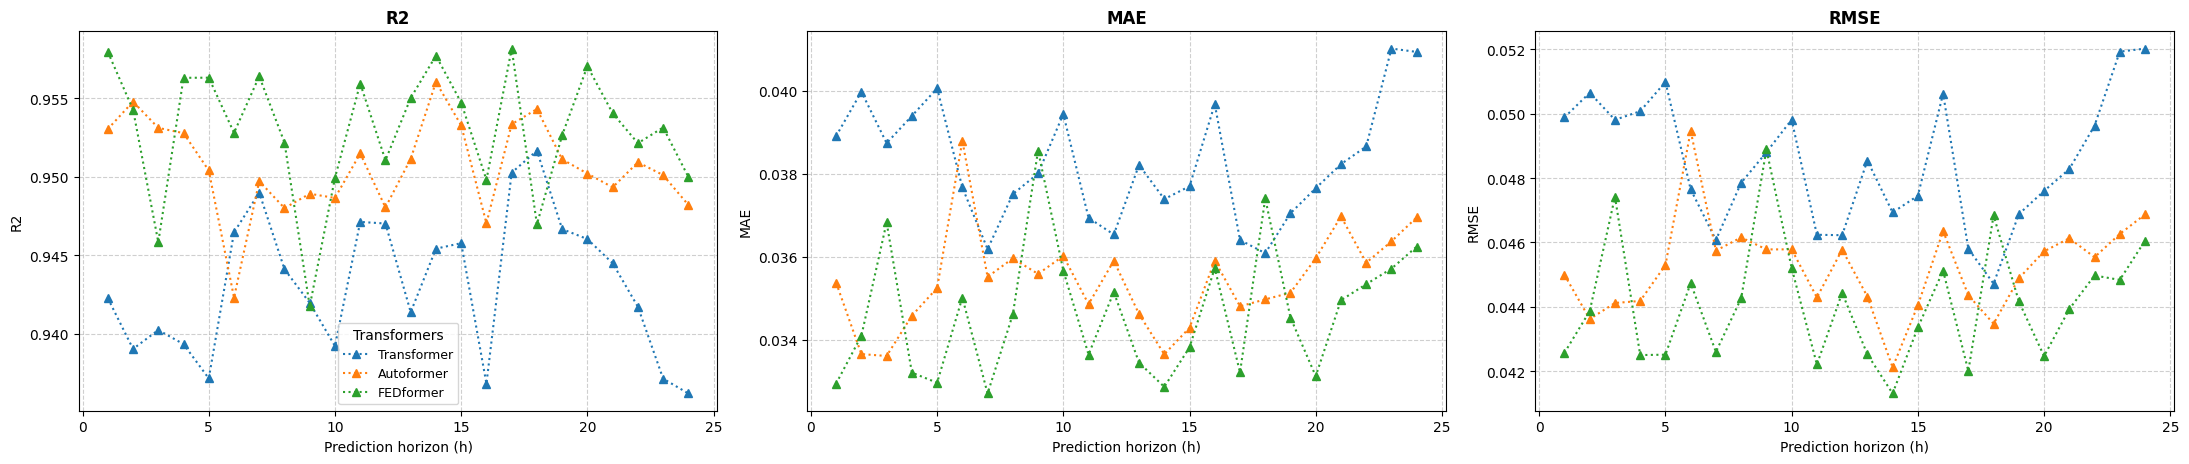

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

metrics = ["R2", "MAE", "RMSE"]

# ===========================================================
# OBTENER LOS RESULTADOS SOLO DE TRANSFORMERS CLÁSICOS
# ===========================================================
df_pointwise_tf = experiment_results_tf["global"]["pointwise_all"]

transformer_models = ["Transformer", "Autoformer", "FEDformer"]

fig, axes = plt.subplots(1, 3, figsize=(22, 5))
plt.subplots_adjust(wspace=0.3)

for i, metric in enumerate(metrics):
    ax = axes[i]

    # ===== TRANSFORMERS CLÁSICOS =====
    for name in transformer_models:
        subset = df_pointwise_tf[df_pointwise_tf["model"] == name]
        if not subset.empty:
            ax.plot(
                subset["horizon"],
                subset[metric],
                linestyle=":",
                marker="^",
                label=name
            )

    # ===== CONFIGURACIÓN DE ESTILO =====
    ax.set_title(f"{metric}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Prediction horizon (h)")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.6)

    if i == 0:
        ax.legend(title="Transformers", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


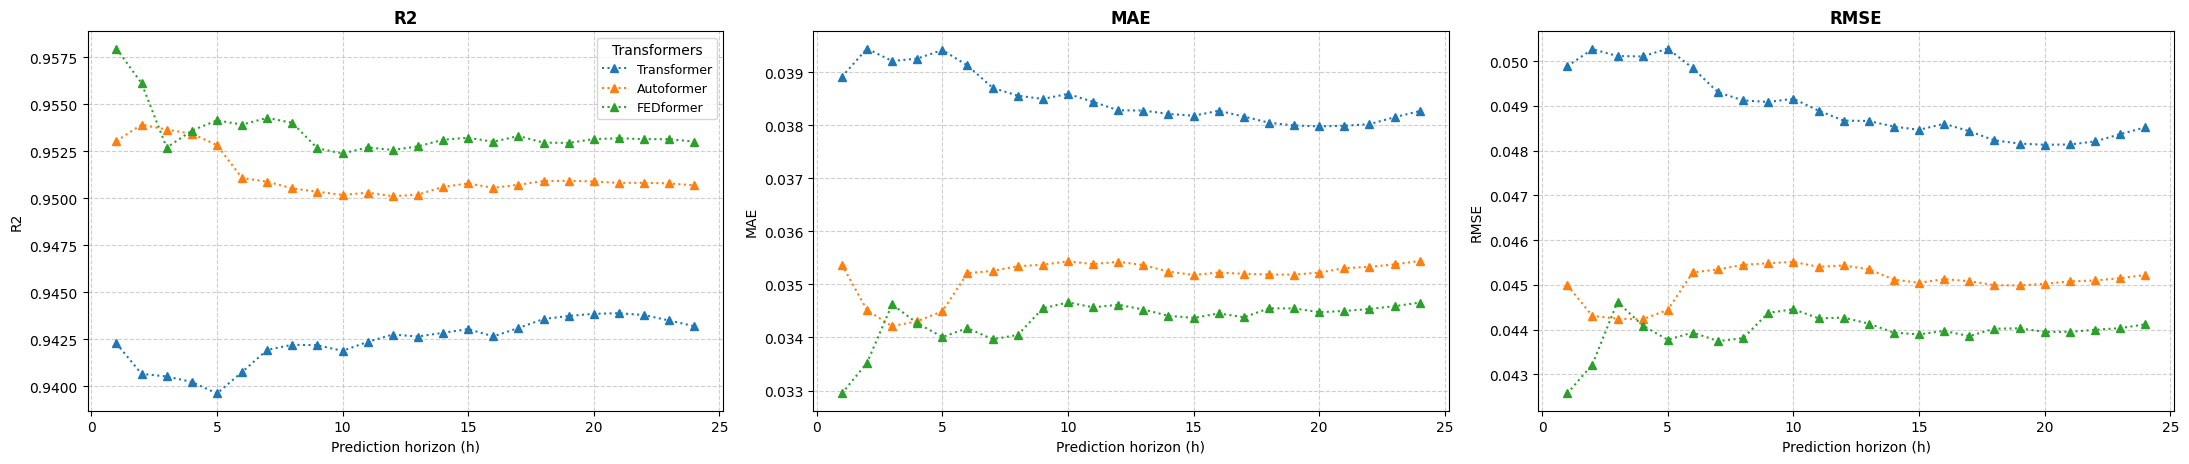

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

metrics = ["R2", "MAE", "RMSE"]

# ===========================================================
# OBTENER SOLO LOS RESULTADOS DE TRANSFORMERS CLÁSICOS
# ===========================================================
df_pointwise_tf = experiment_results_tf["global"]["pointwise_all"].copy()

transformer_models = ["Transformer", "Autoformer", "FEDformer"]

# ===========================================================
# GENERAR VERSIÓN ACUMULADA (expanding)
# ===========================================================
df_cumulative_tf = (
    df_pointwise_tf
    .sort_values(["model", "horizon"])
    .groupby("model", group_keys=False)
    .apply(lambda g: g.assign(
        R2=g["R2"].expanding().mean(),
        MAE=g["MAE"].expanding().mean(),
        RMSE=g["RMSE"].expanding().mean()
    ))
)

# ===========================================================
# FIGURA MULTIPANEL
# ===========================================================
fig, axes = plt.subplots(1, 3, figsize=(22, 5))
plt.subplots_adjust(wspace=0.3)

for i, metric in enumerate(metrics):
    ax = axes[i]

    # ===== TRANSFORMERS CLÁSICOS =====
    for name in transformer_models:
        subset = df_cumulative_tf[df_cumulative_tf["model"] == name]
        if not subset.empty:
            ax.plot(
                subset["horizon"],
                subset[metric],
                linestyle=":",
                marker="^",
                label=name
            )

    # ===== Configuración de estilo =====
    ax.set_title(metric, fontsize=12, fontweight="bold")
    ax.set_xlabel("Prediction horizon (h)")
    ax.set_ylabel(metric)
    ax.grid(True, linestyle="--", alpha=0.6)

    if i == 0:
        ax.legend(title="Transformers", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


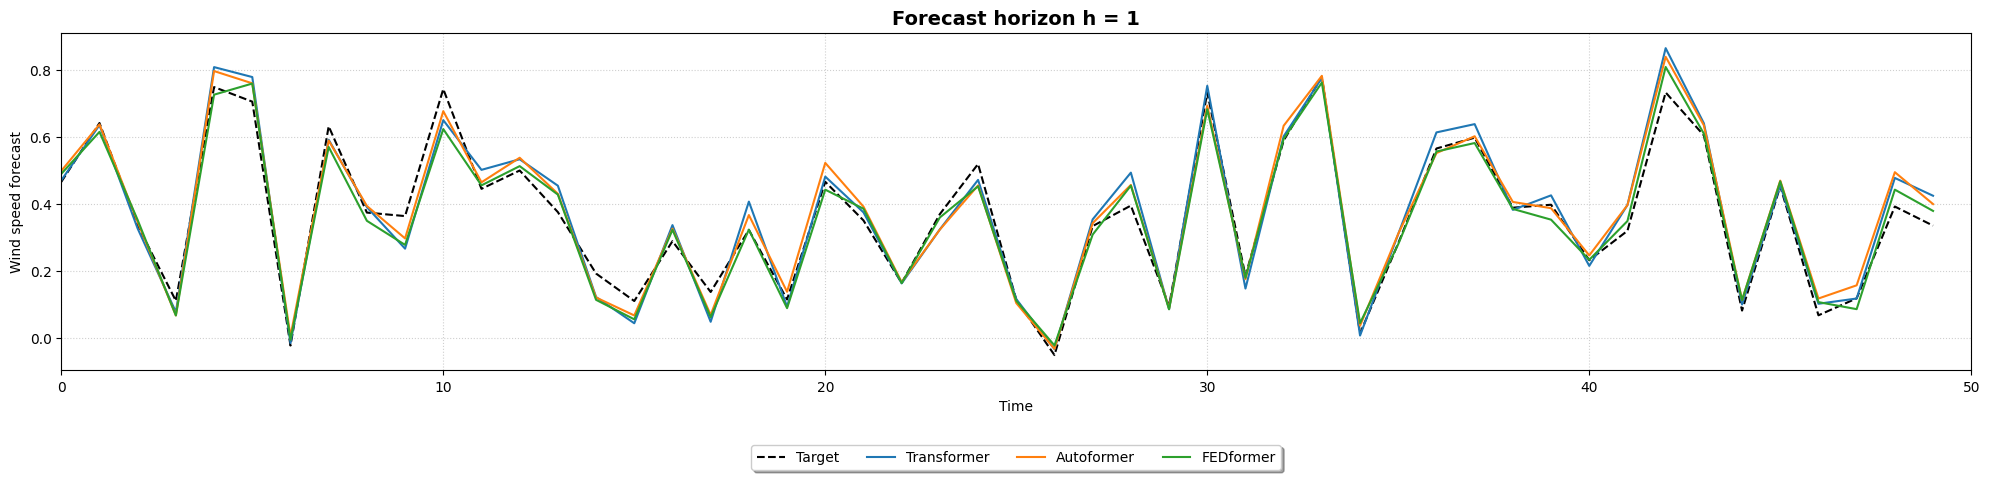

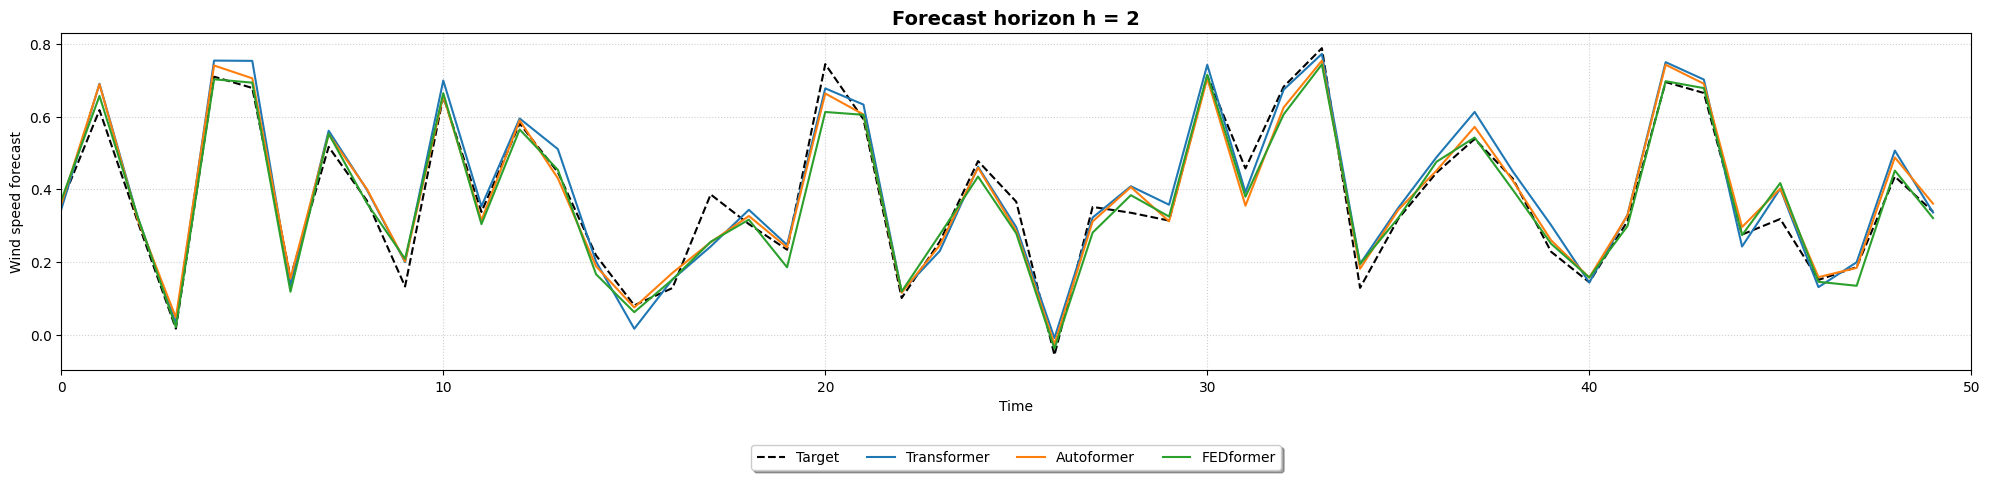

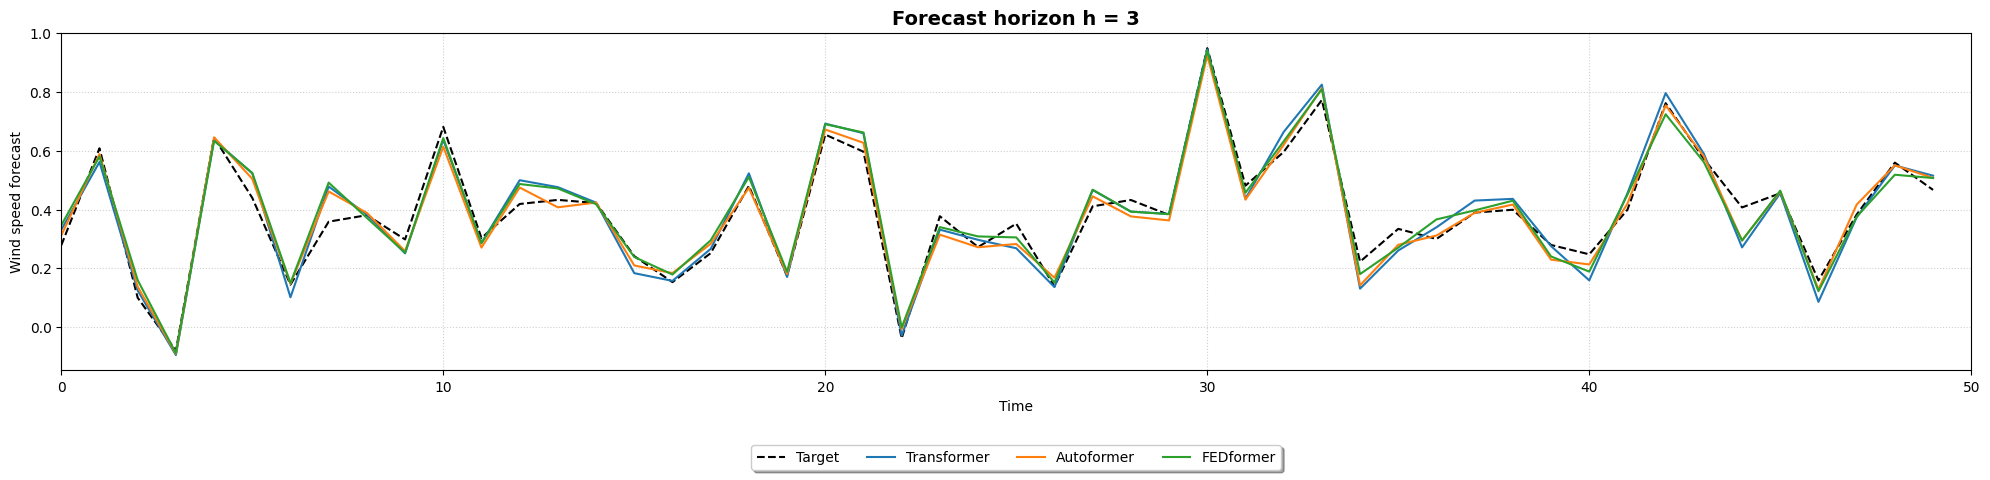

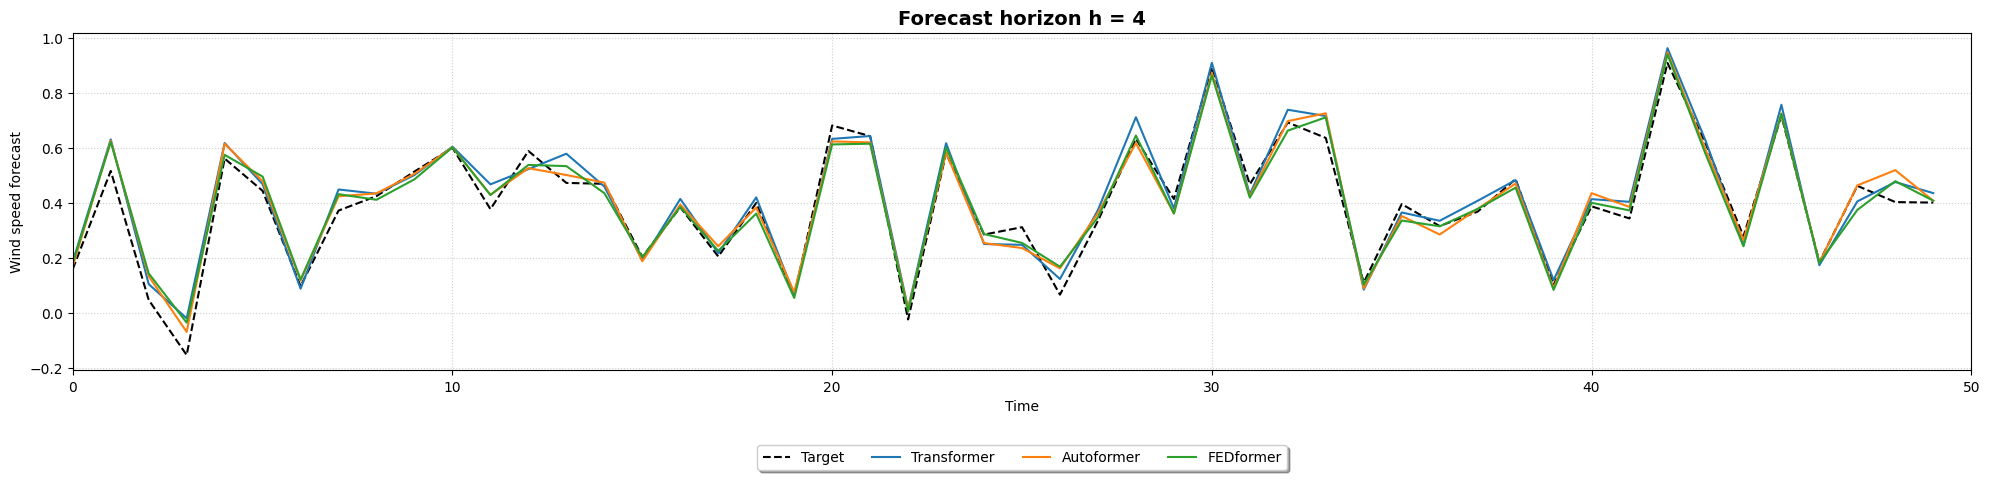

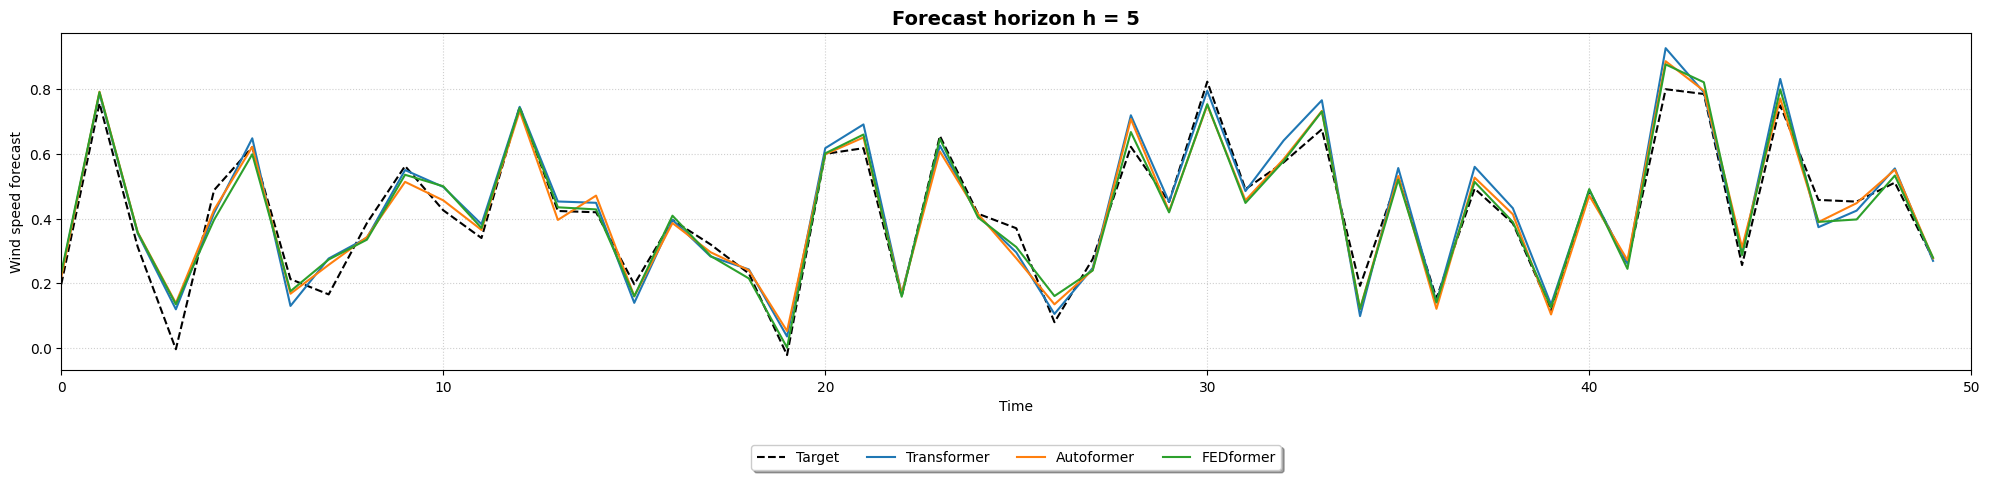

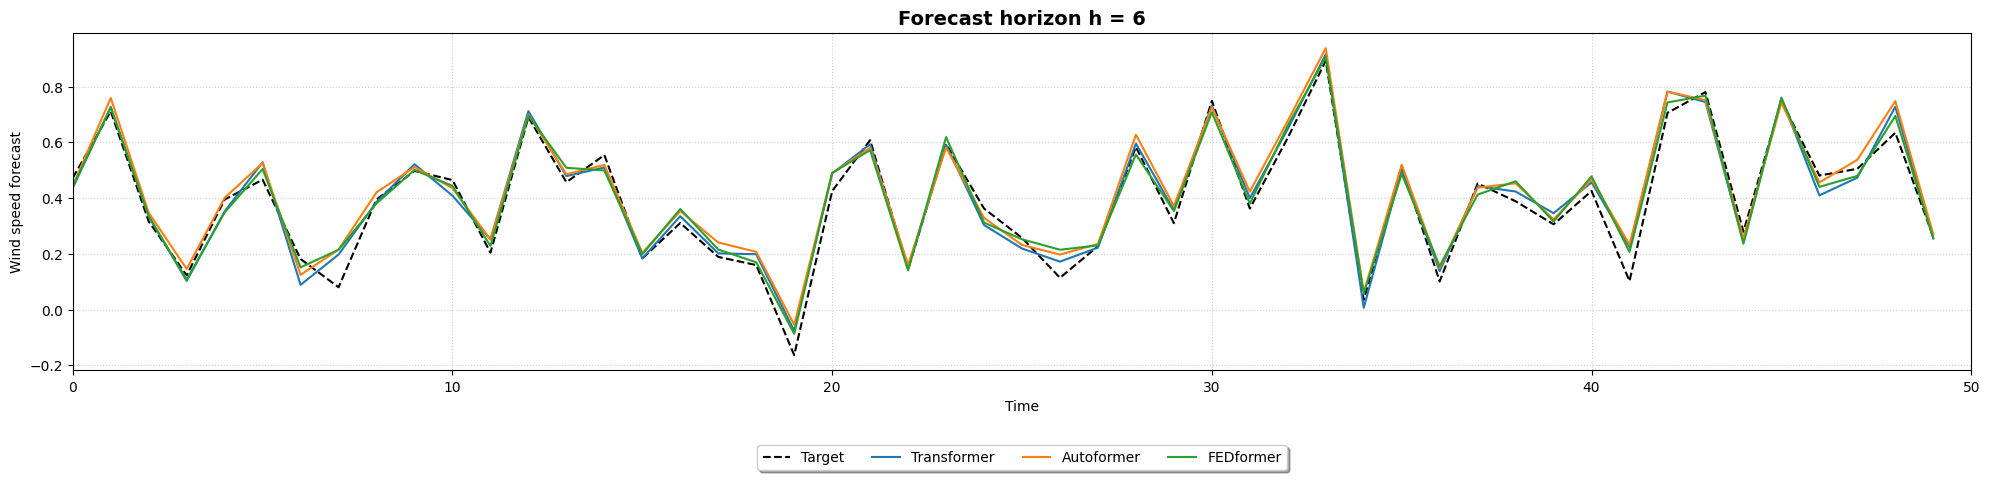

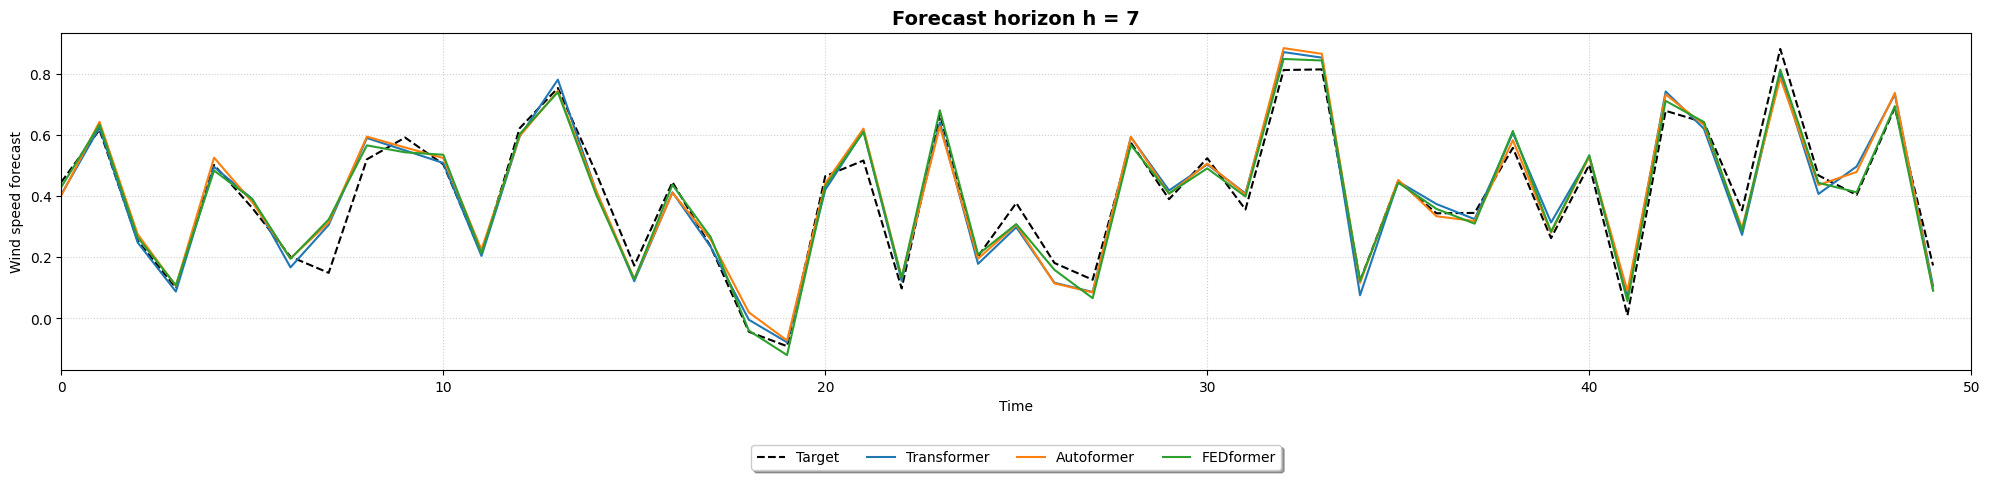

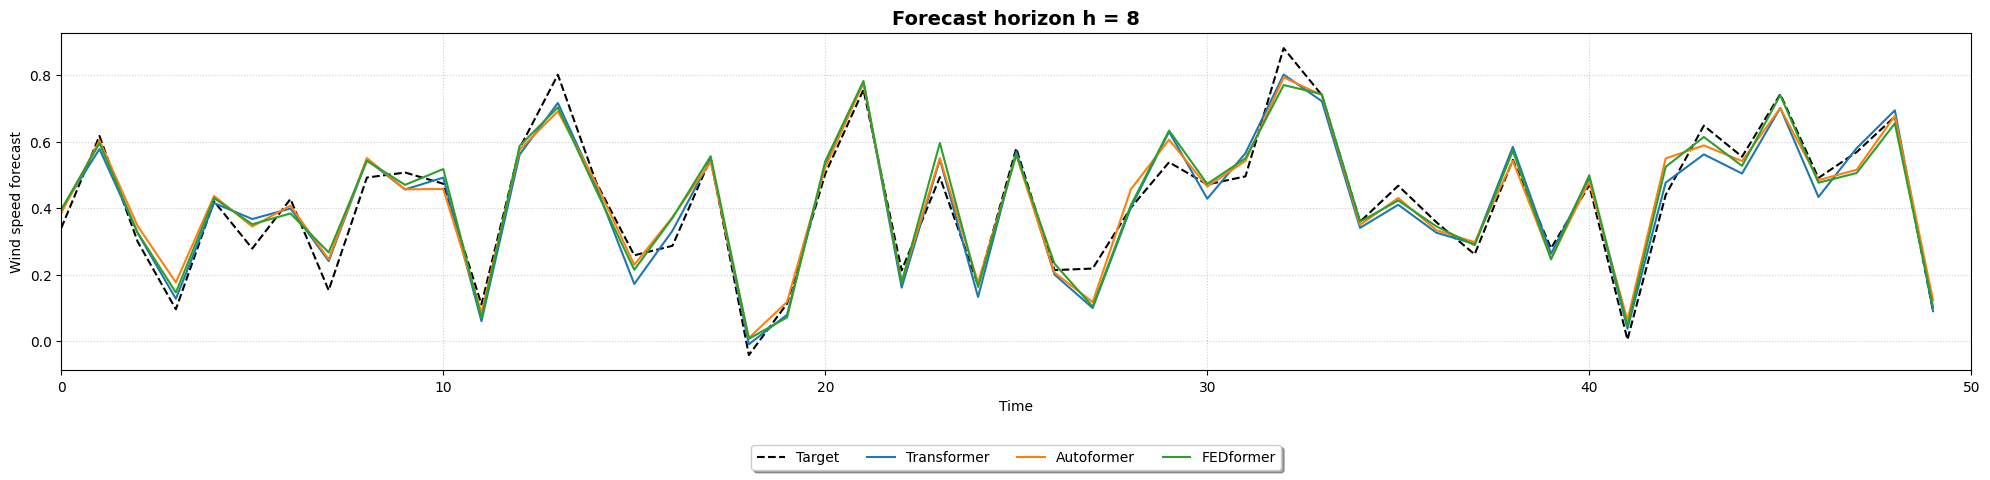

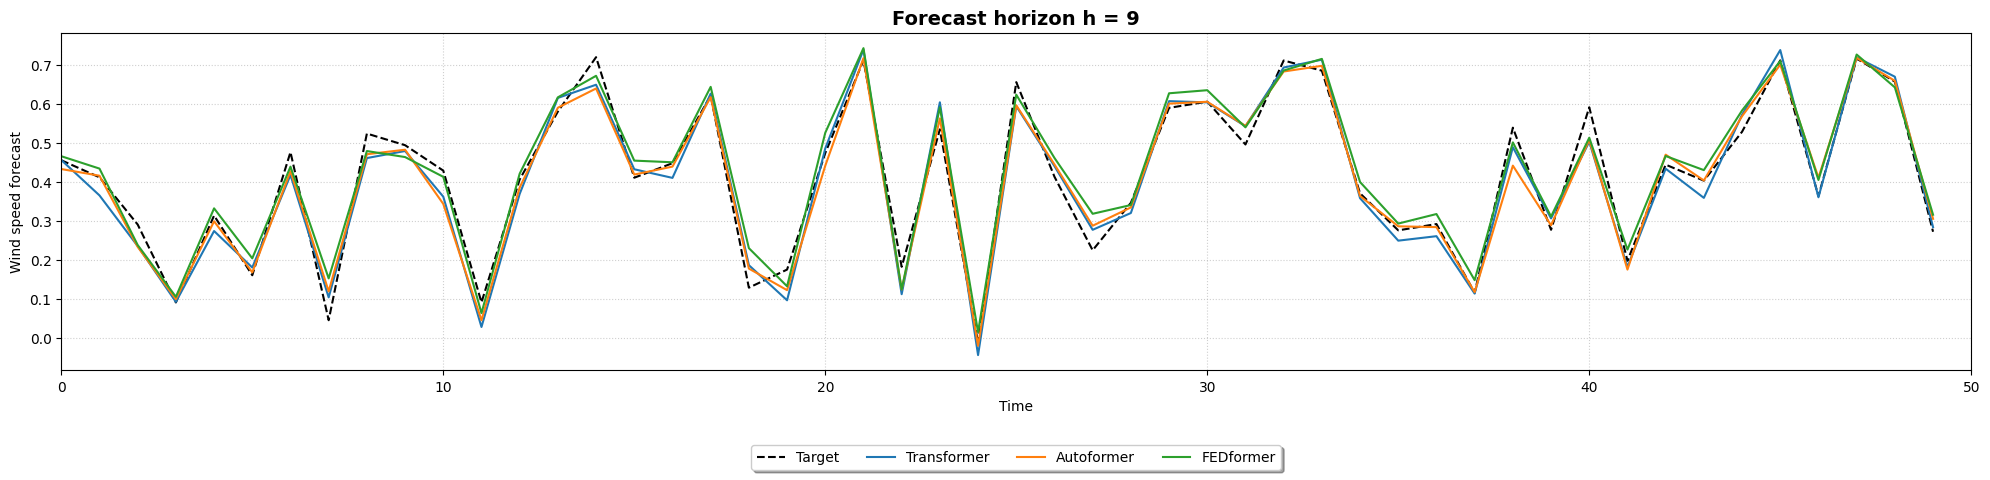

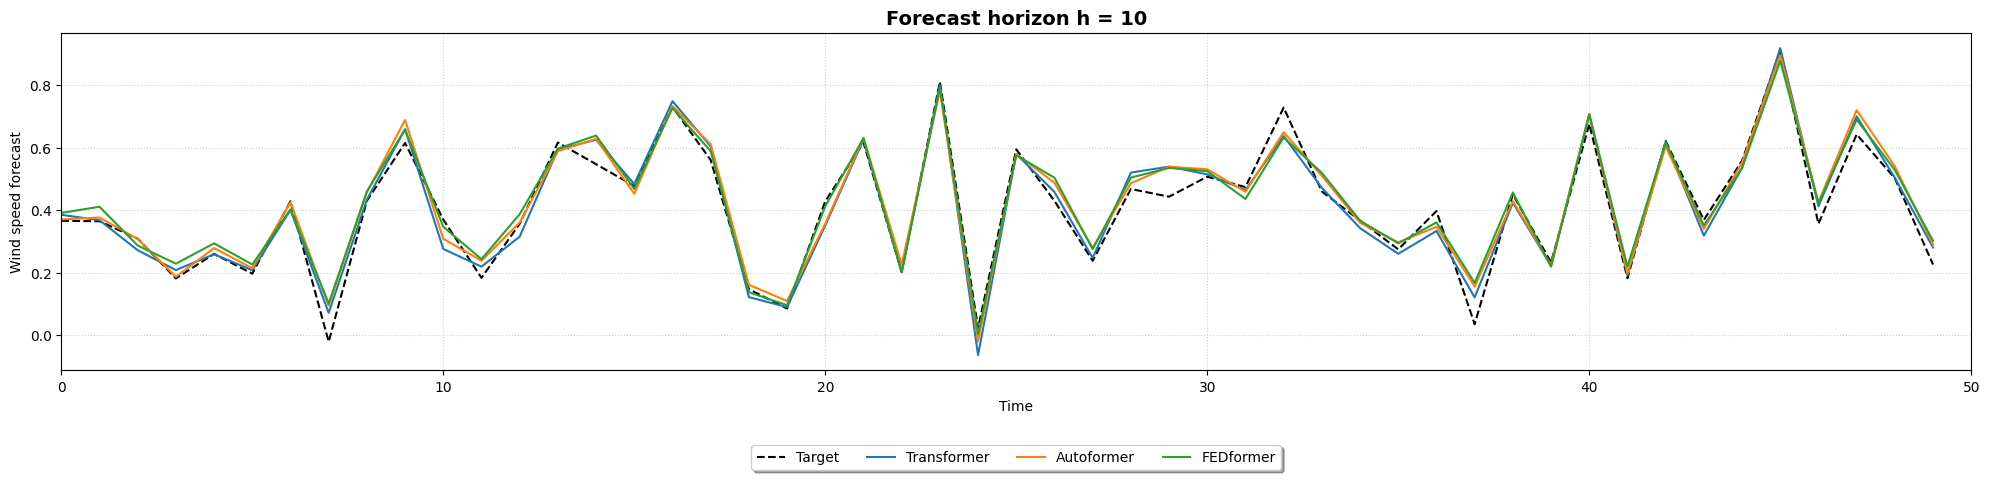

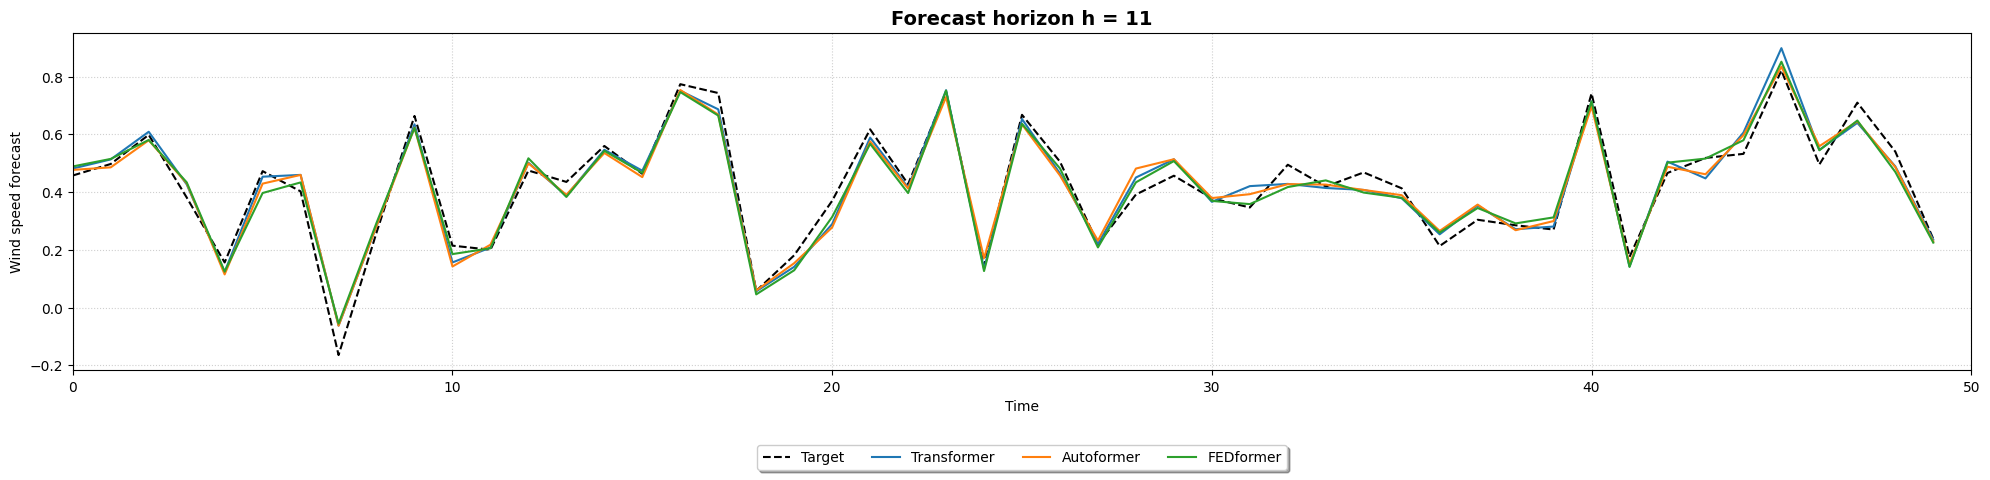

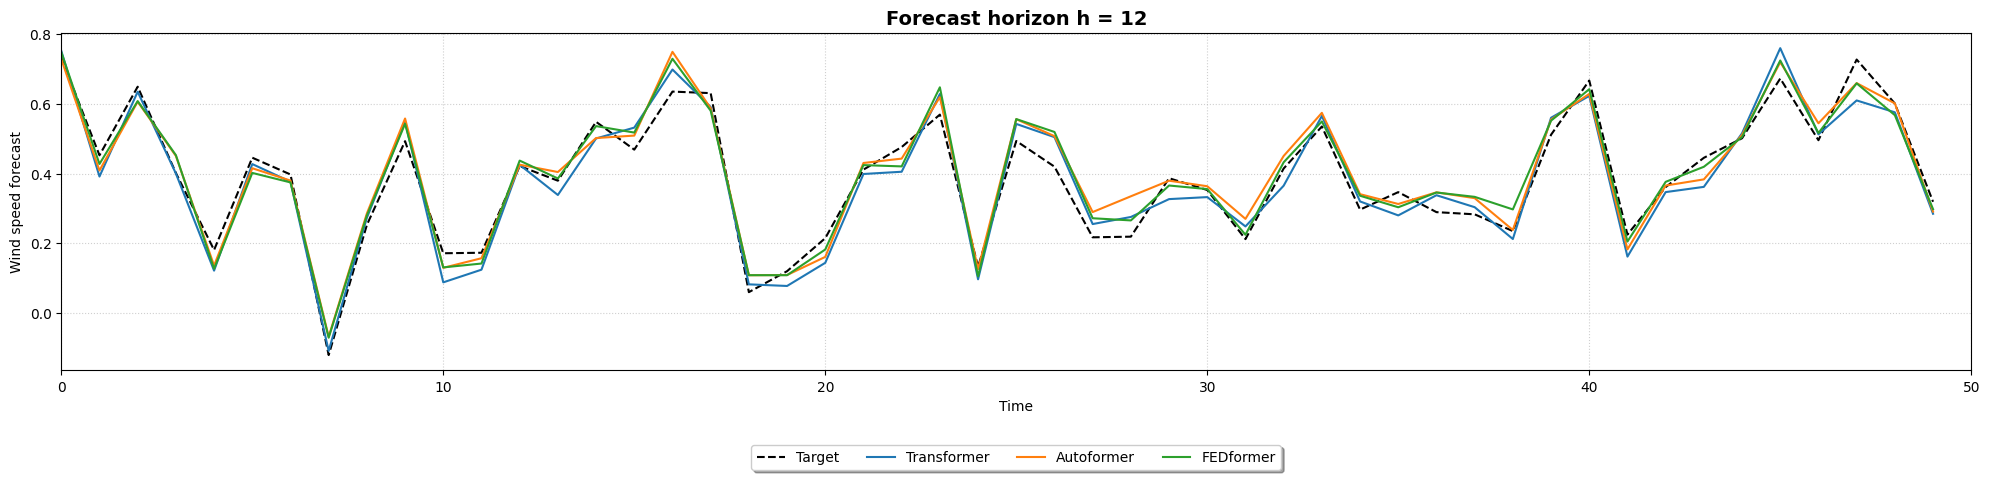

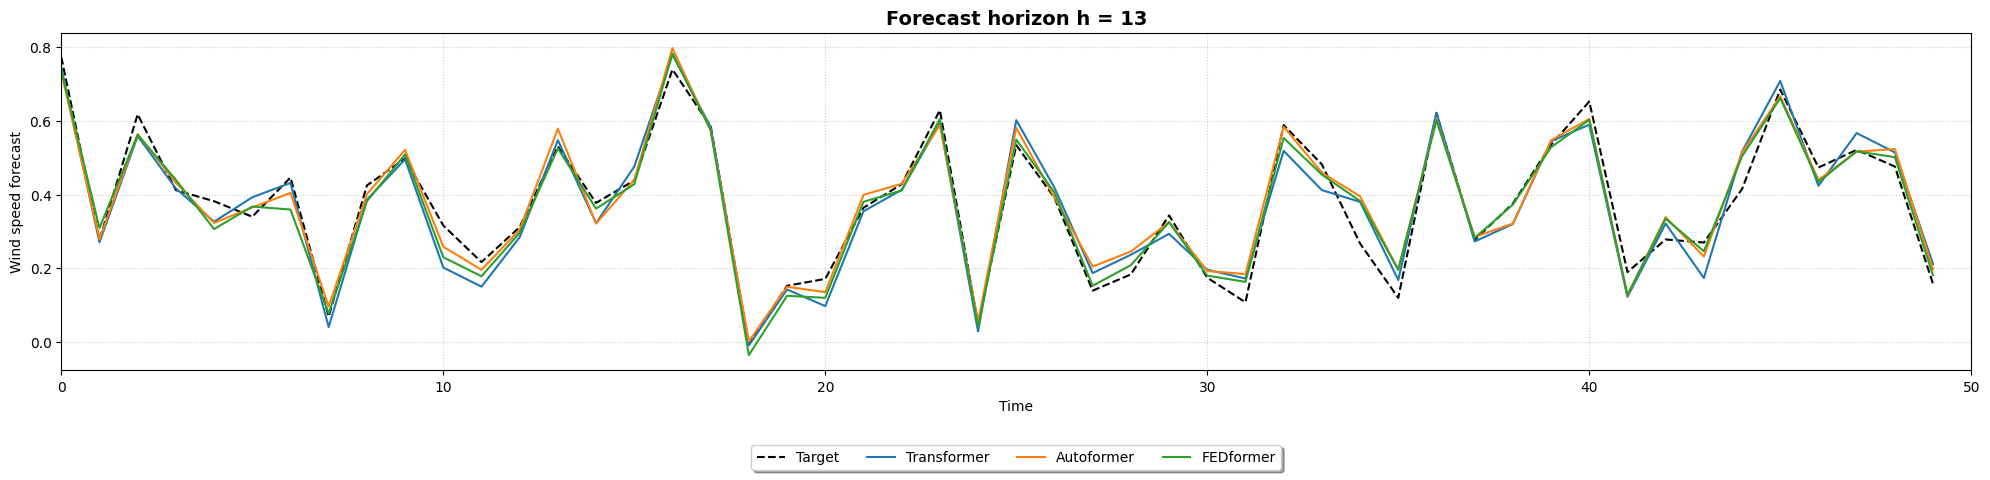

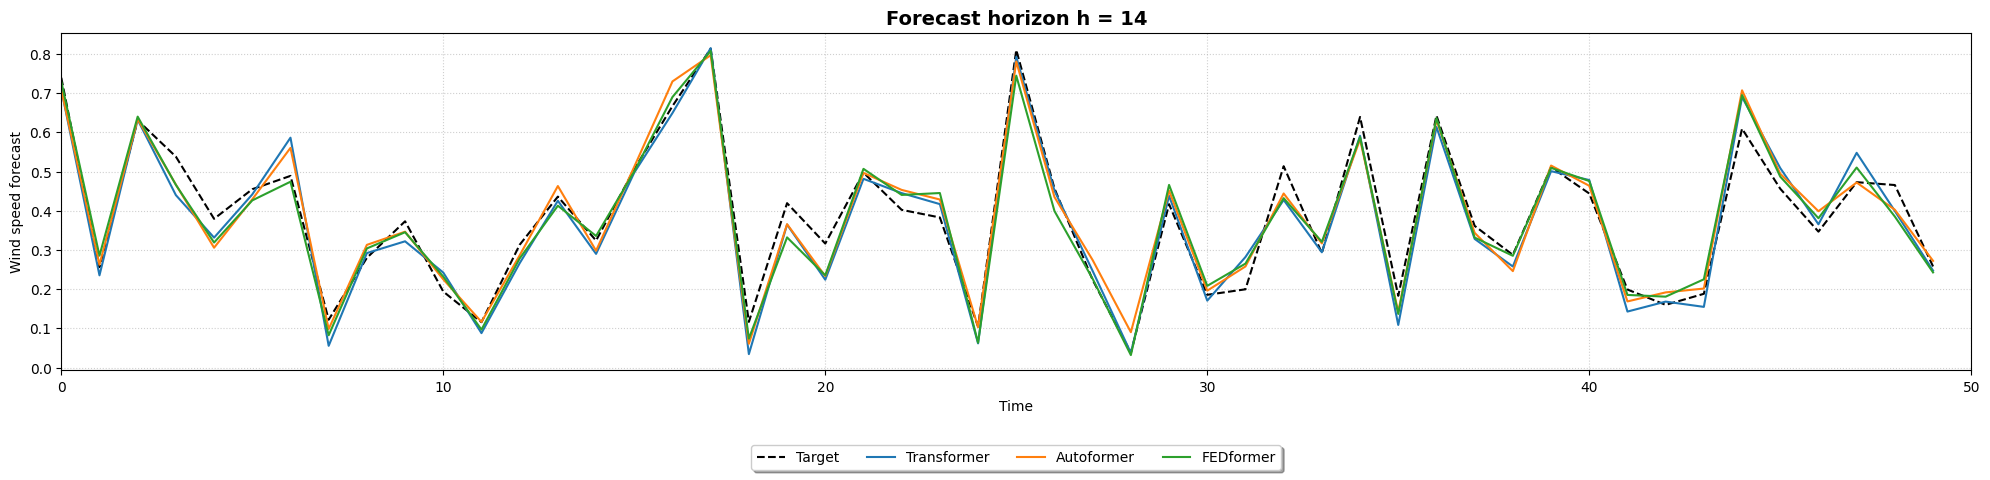

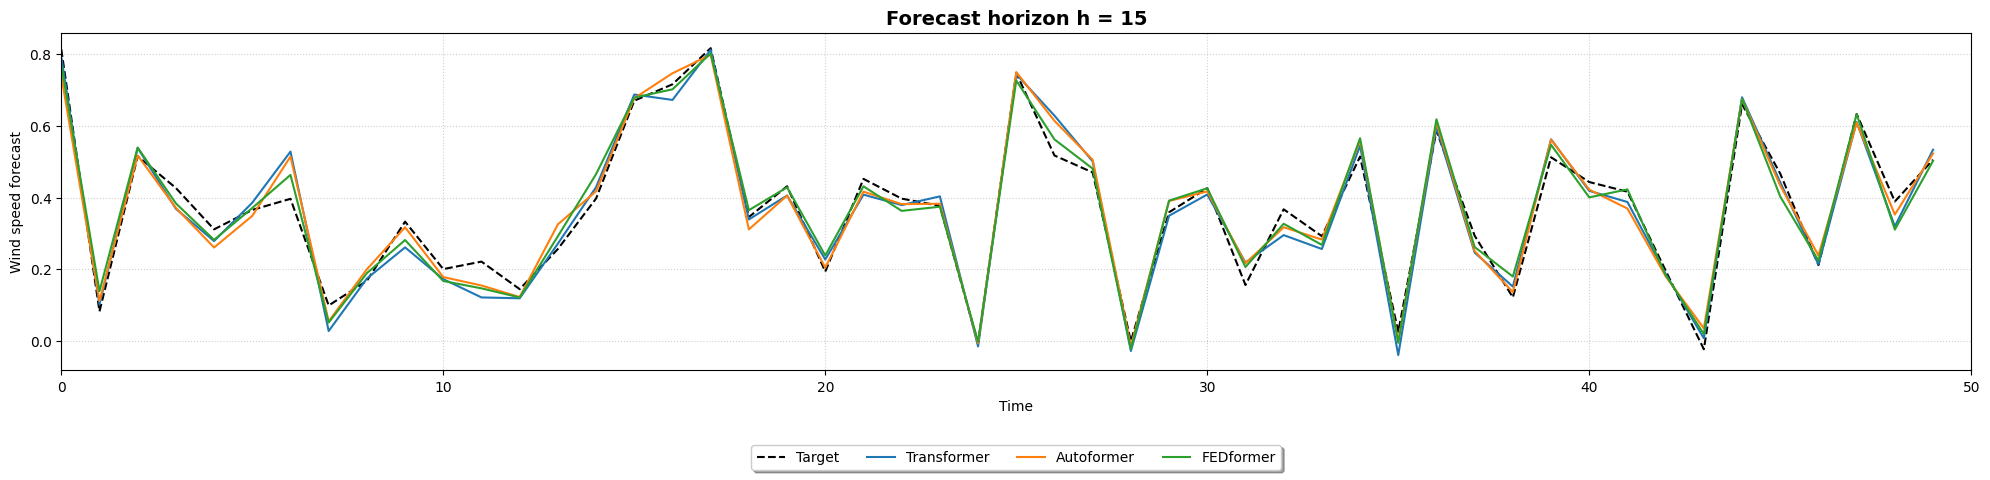

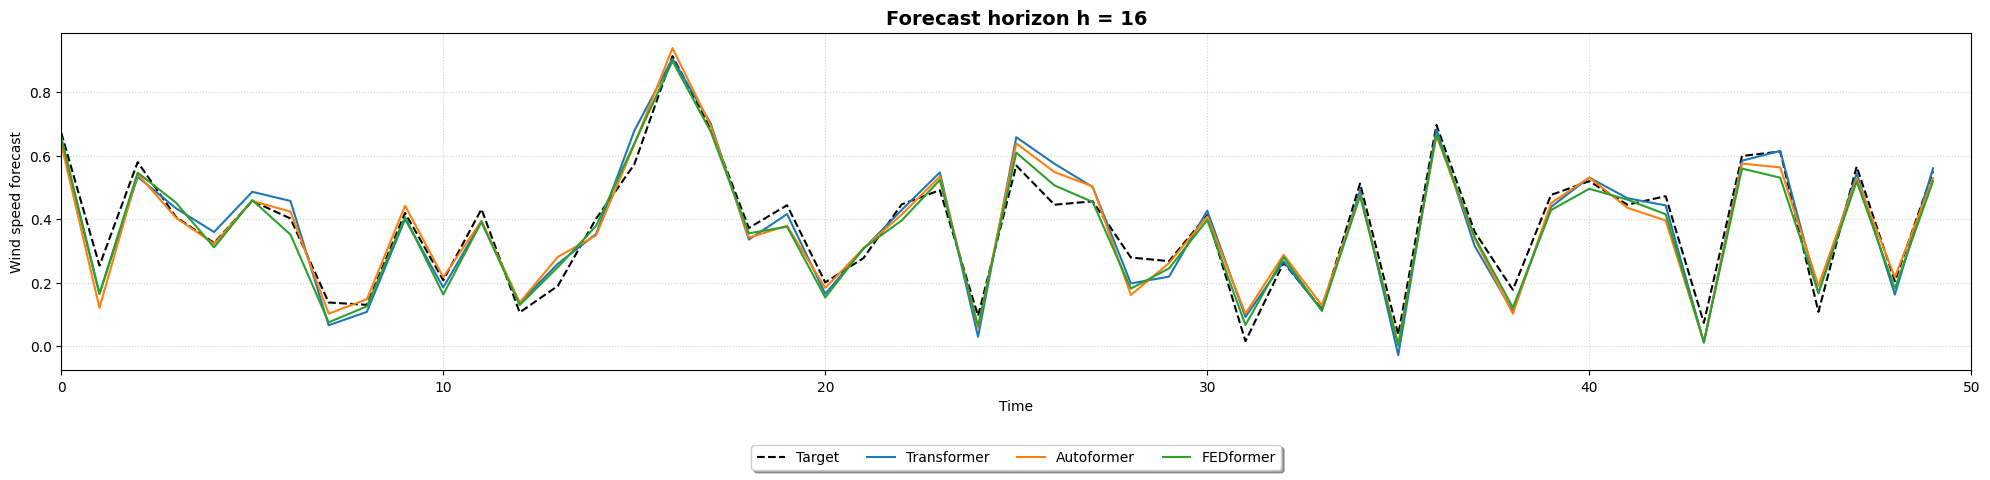

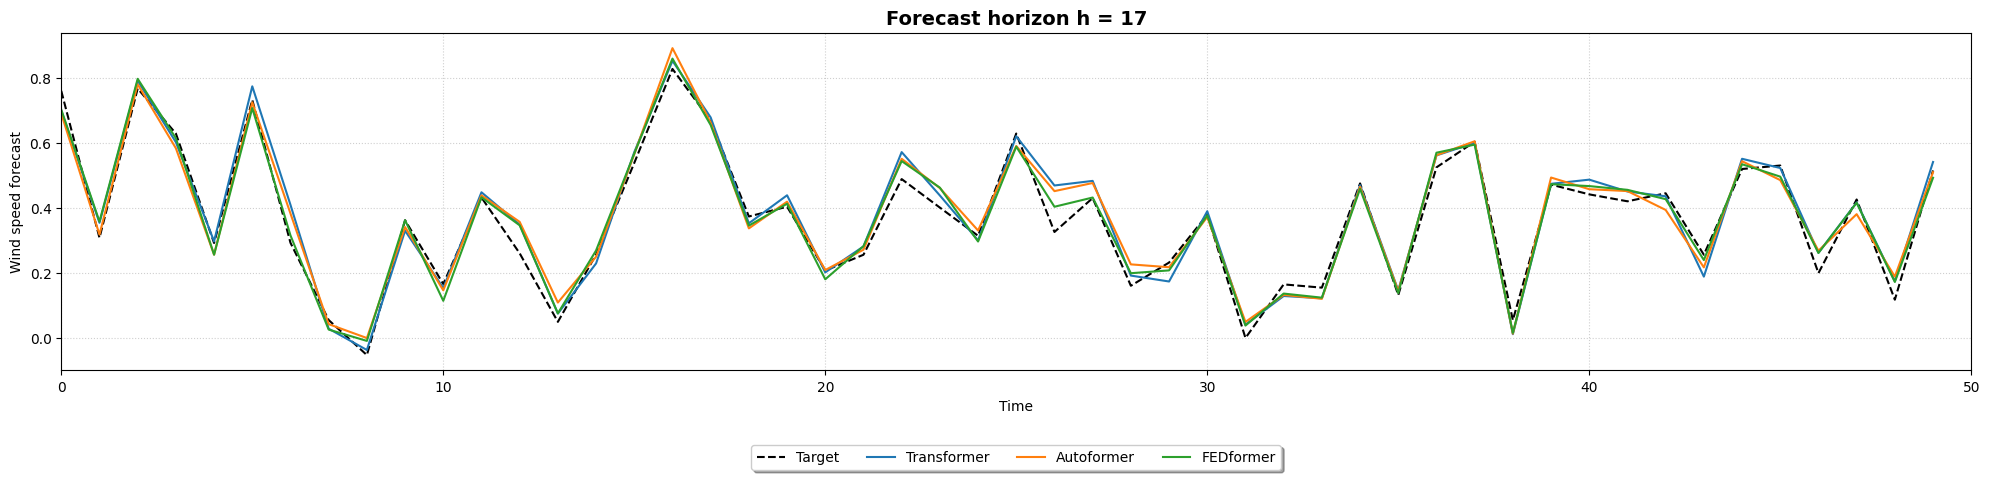

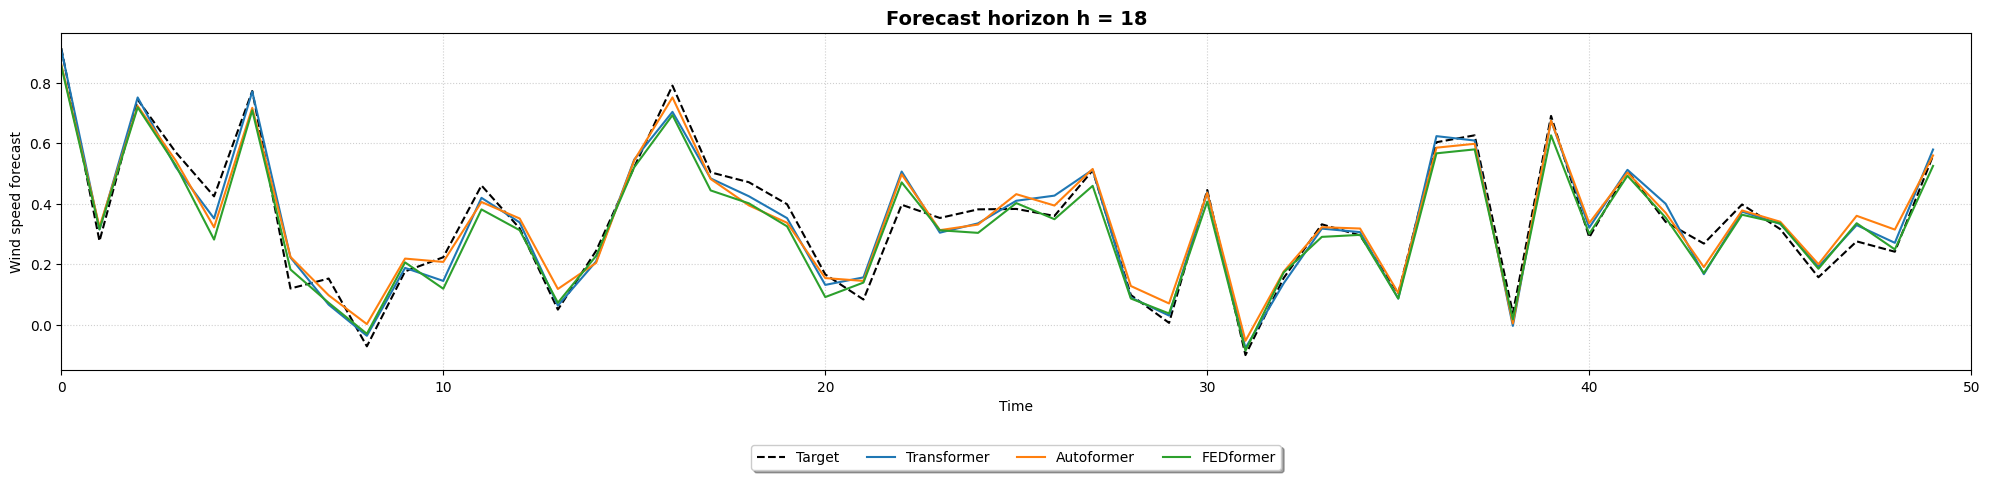

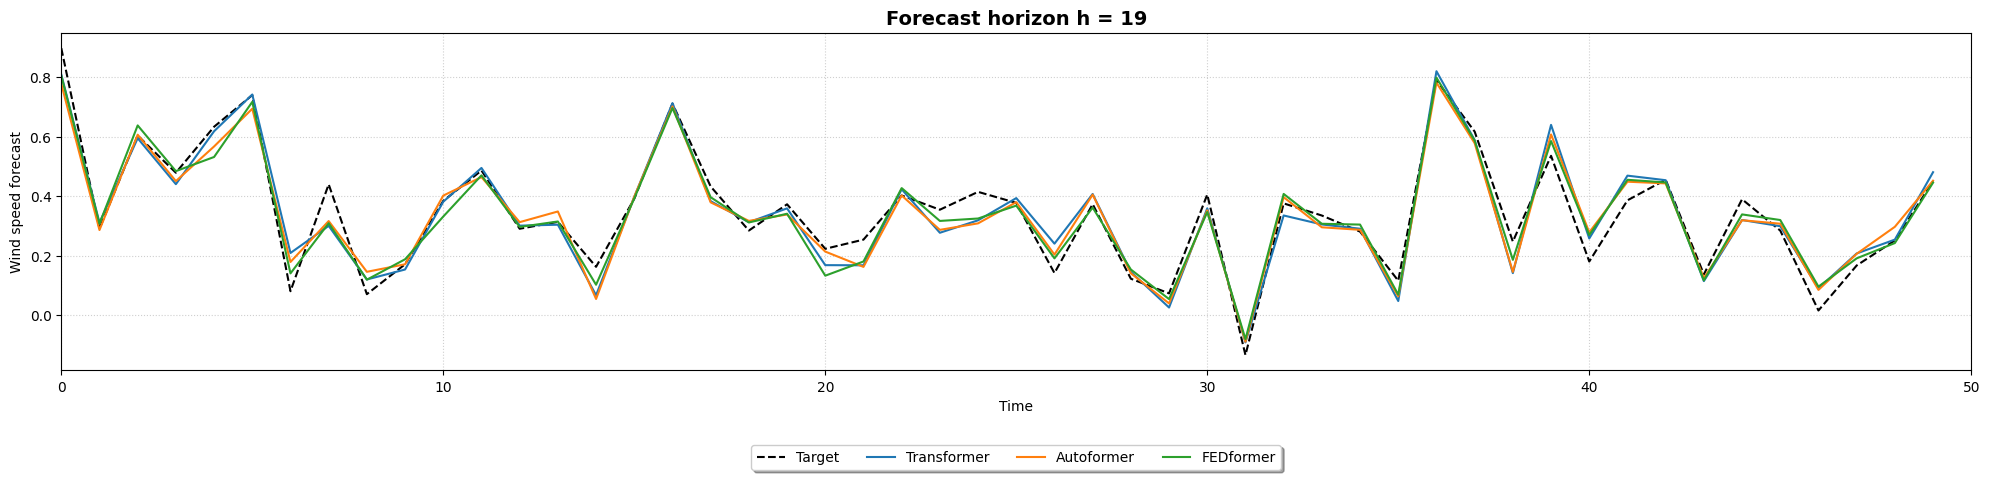

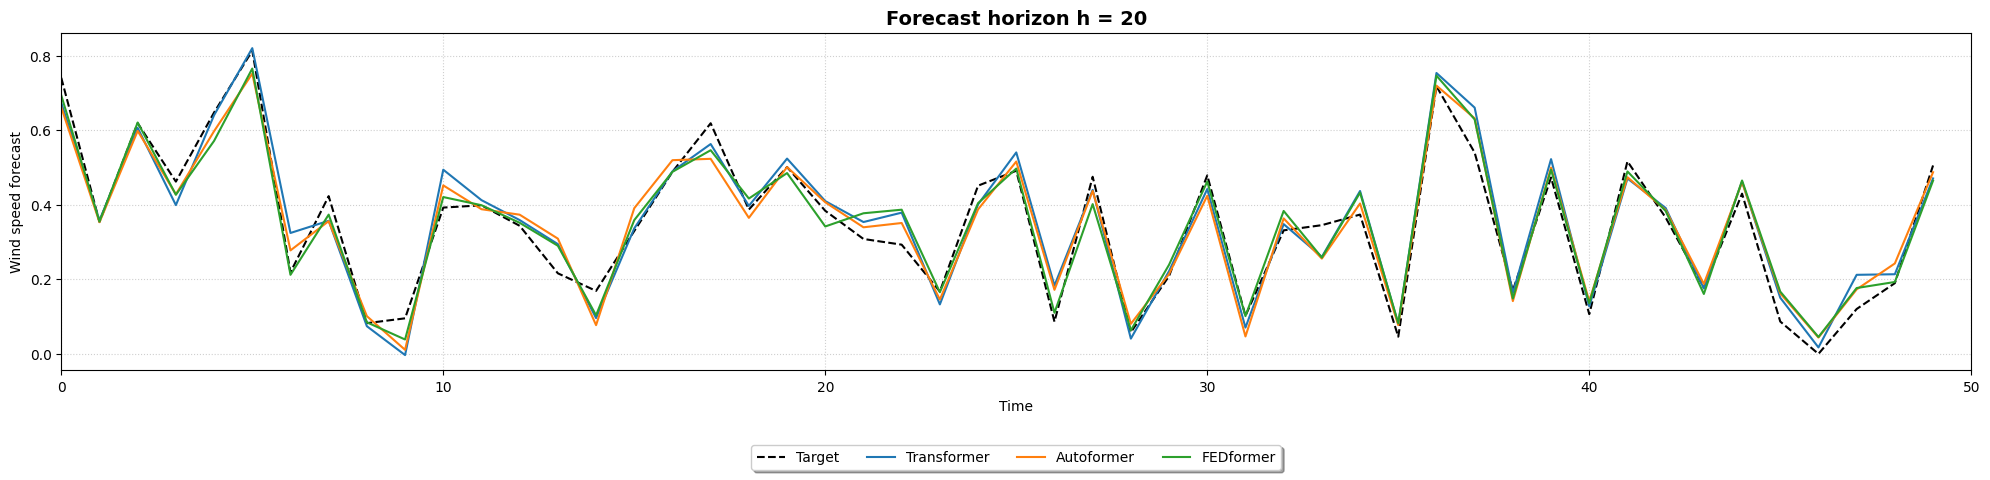

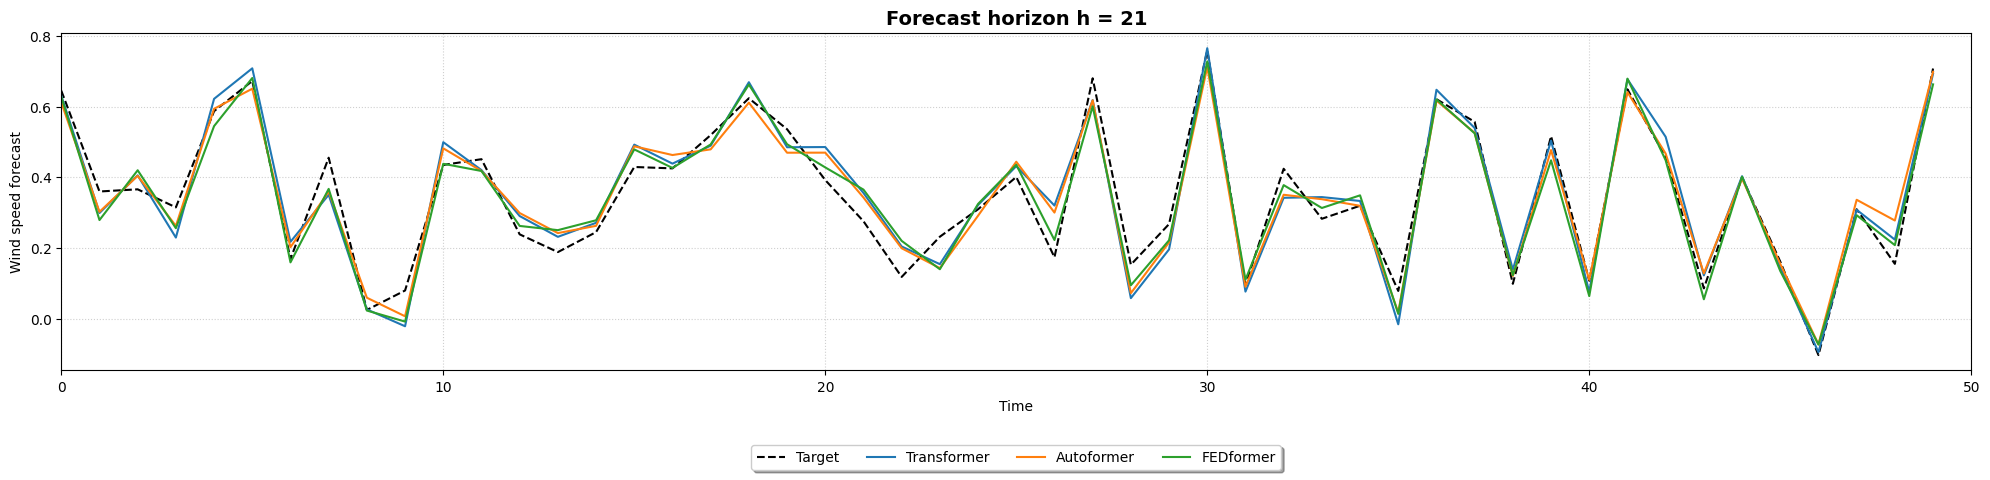

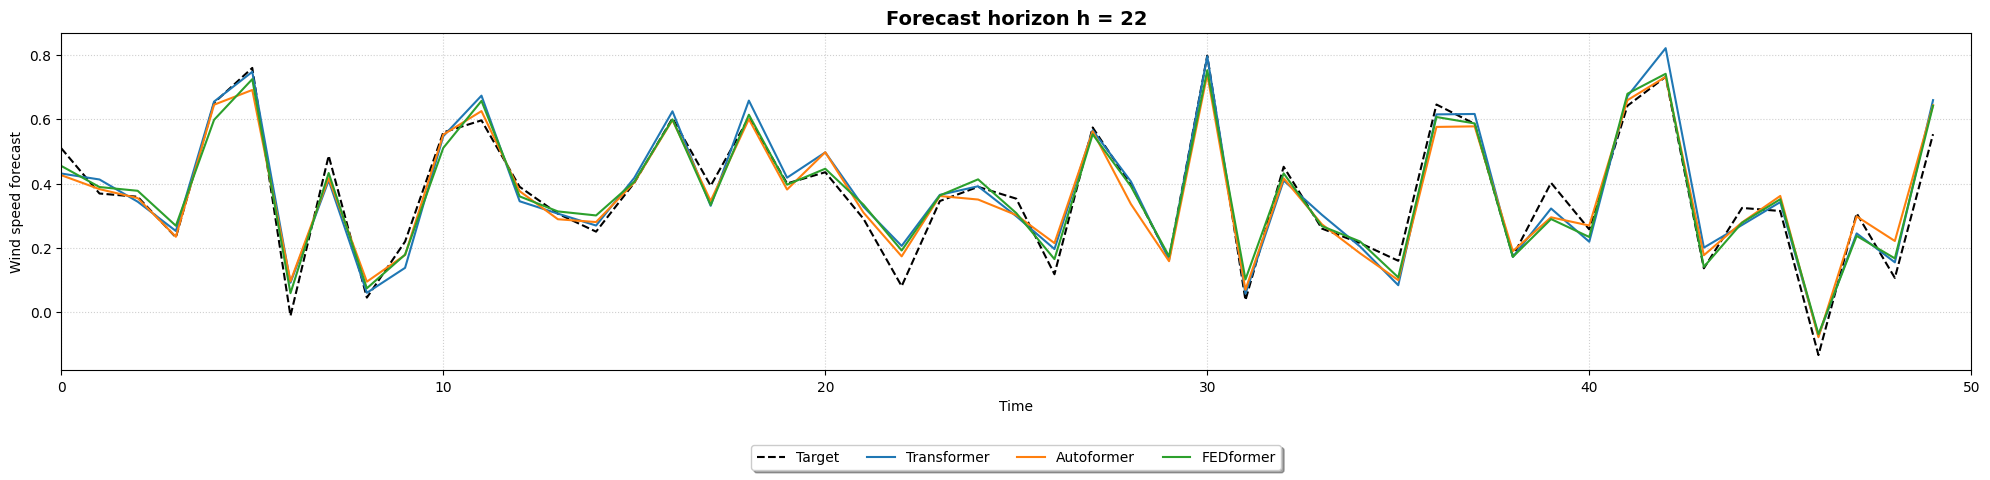

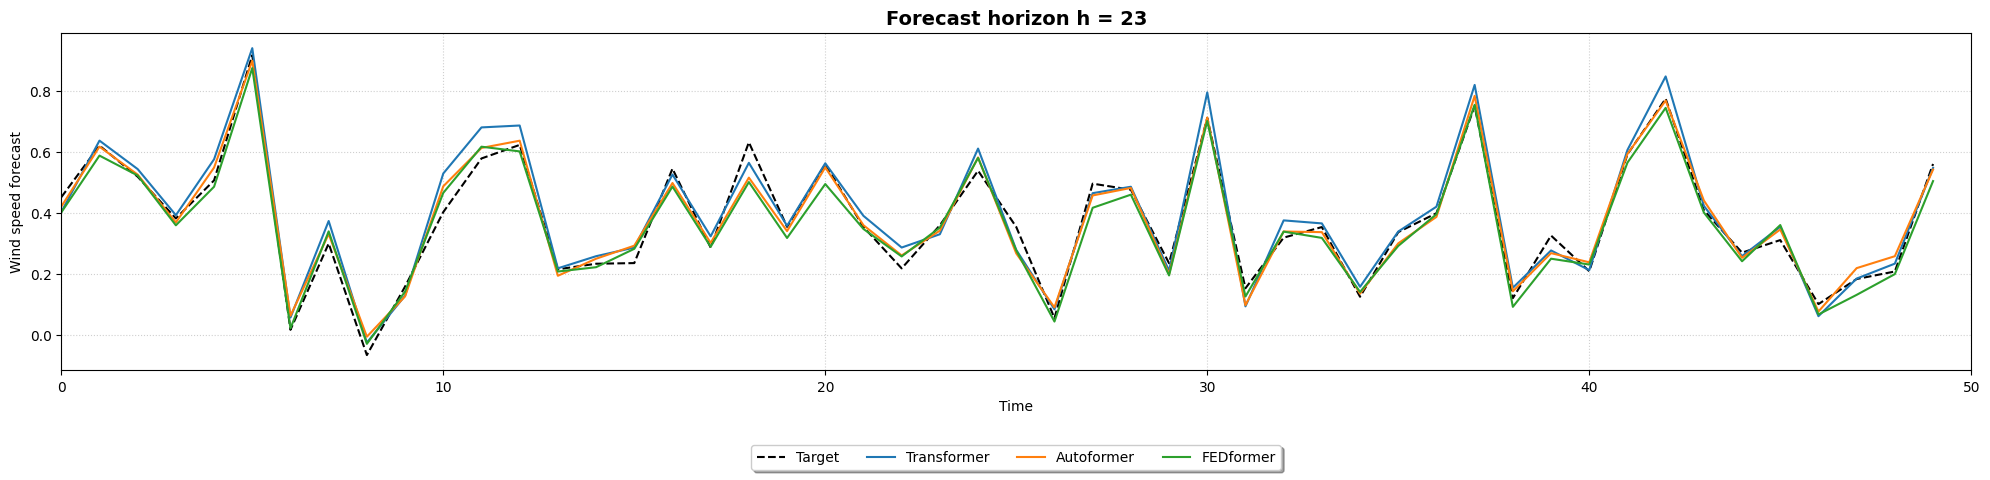

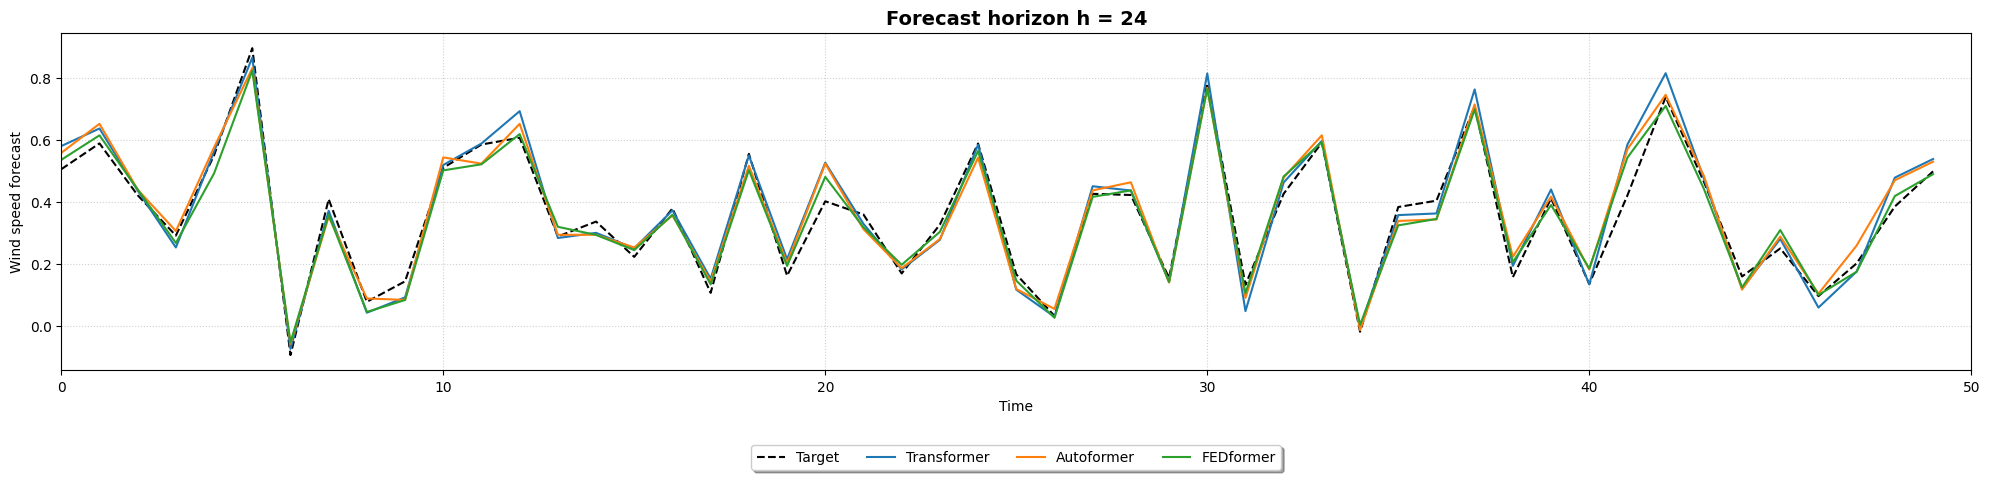

In [30]:
# ===========================================================
# GRAFICAR PRONÓSTICOS POR HORIZONTE (H pasos adelante)
# ===========================================================

H = experiment_results_tf["config"]["models_included"][0]  # o el valor que tú uses para horizon
# Si horizon está en args:
H = list(experiment_results_tf["models"].values())[0]["args"]["horizon"]

# Acceder a los pronósticos
forecast_dict = {
    model_name: (
        model_info["forecast"]["y_true"],
        model_info["forecast"]["y_pred"]
    )
    for model_name, model_info in experiment_results_tf["models"].items()
}

for i in range(H):
    plt.figure(figsize=(20, 5))
    target_plotted = False

    for model_name, (y_true_data, y_pred_data) in forecast_dict.items():

        # Recuperar y_true una sola vez
        if not target_plotted:
            y_true = y_true_data[0:50, i]        # primeros 50 puntos
            plt.plot(y_true, label="Target",
                     linestyle='dashed', color='black')
            target_plotted = True

        # Predicción del modelo
        y_pred = y_pred_data[0:50, i]
        plt.plot(y_pred, label=model_name)

    # ===== CONFIGURACIÓN DEL GRÁFICO =====
    plt.xlim(0, 50)
    plt.xlabel("Time")
    plt.ylabel("Wind speed forecast")
    plt.title(f"Forecast horizon h = {i+1}", fontsize=14, fontweight="bold")

    # leyenda centrada abajo
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=len(forecast_dict) + 1,
        fancybox=True,
        shadow=True
    )

    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()
